# MTSSim Simulation
This notebook is used to test the MTSSim port from IDL to python2.7.

In [7]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Let's perform three tests for an MTS extended source observation. The blackbody source is set to 800K, 600K, and 400K respectively. This test setup is chosen in order to compare with the IDL output files that were used to perform the MRS spectrophotometric calibration.

In [1]:
from mtssim import MTSSim
Vdata = {}
for BB_Temp in [800,600,400]:
    Vdata[str(BB_Temp)+'K'] = MTSSim(BB_Temp,'HOLE',100.,'EXT',MIRI='OFF',parfile='inputs_test.txt')

In [2]:
# load past simulations (used to derive the MRS spectrophotometric response)
from astropy.io import fits
MTSSim_SED = {}
for BB_Temp in ['800K','600K','400K']:
    MTSSim_fits = fits.open('/Users/ioannisa/Desktop/python/miri_devel/MRSFluxCal/MIRI_CDP6MRSFluxCal/Mts{}Jy.fits'.format(BB_Temp))
    MTSSim_SED[BB_Temp] = MTSSim_fits[1].data['SPC'][0]
MTSSim_wav = MTSSim_fits[1].data['WAVE'][0]

<IPython.core.display.Javascript object>


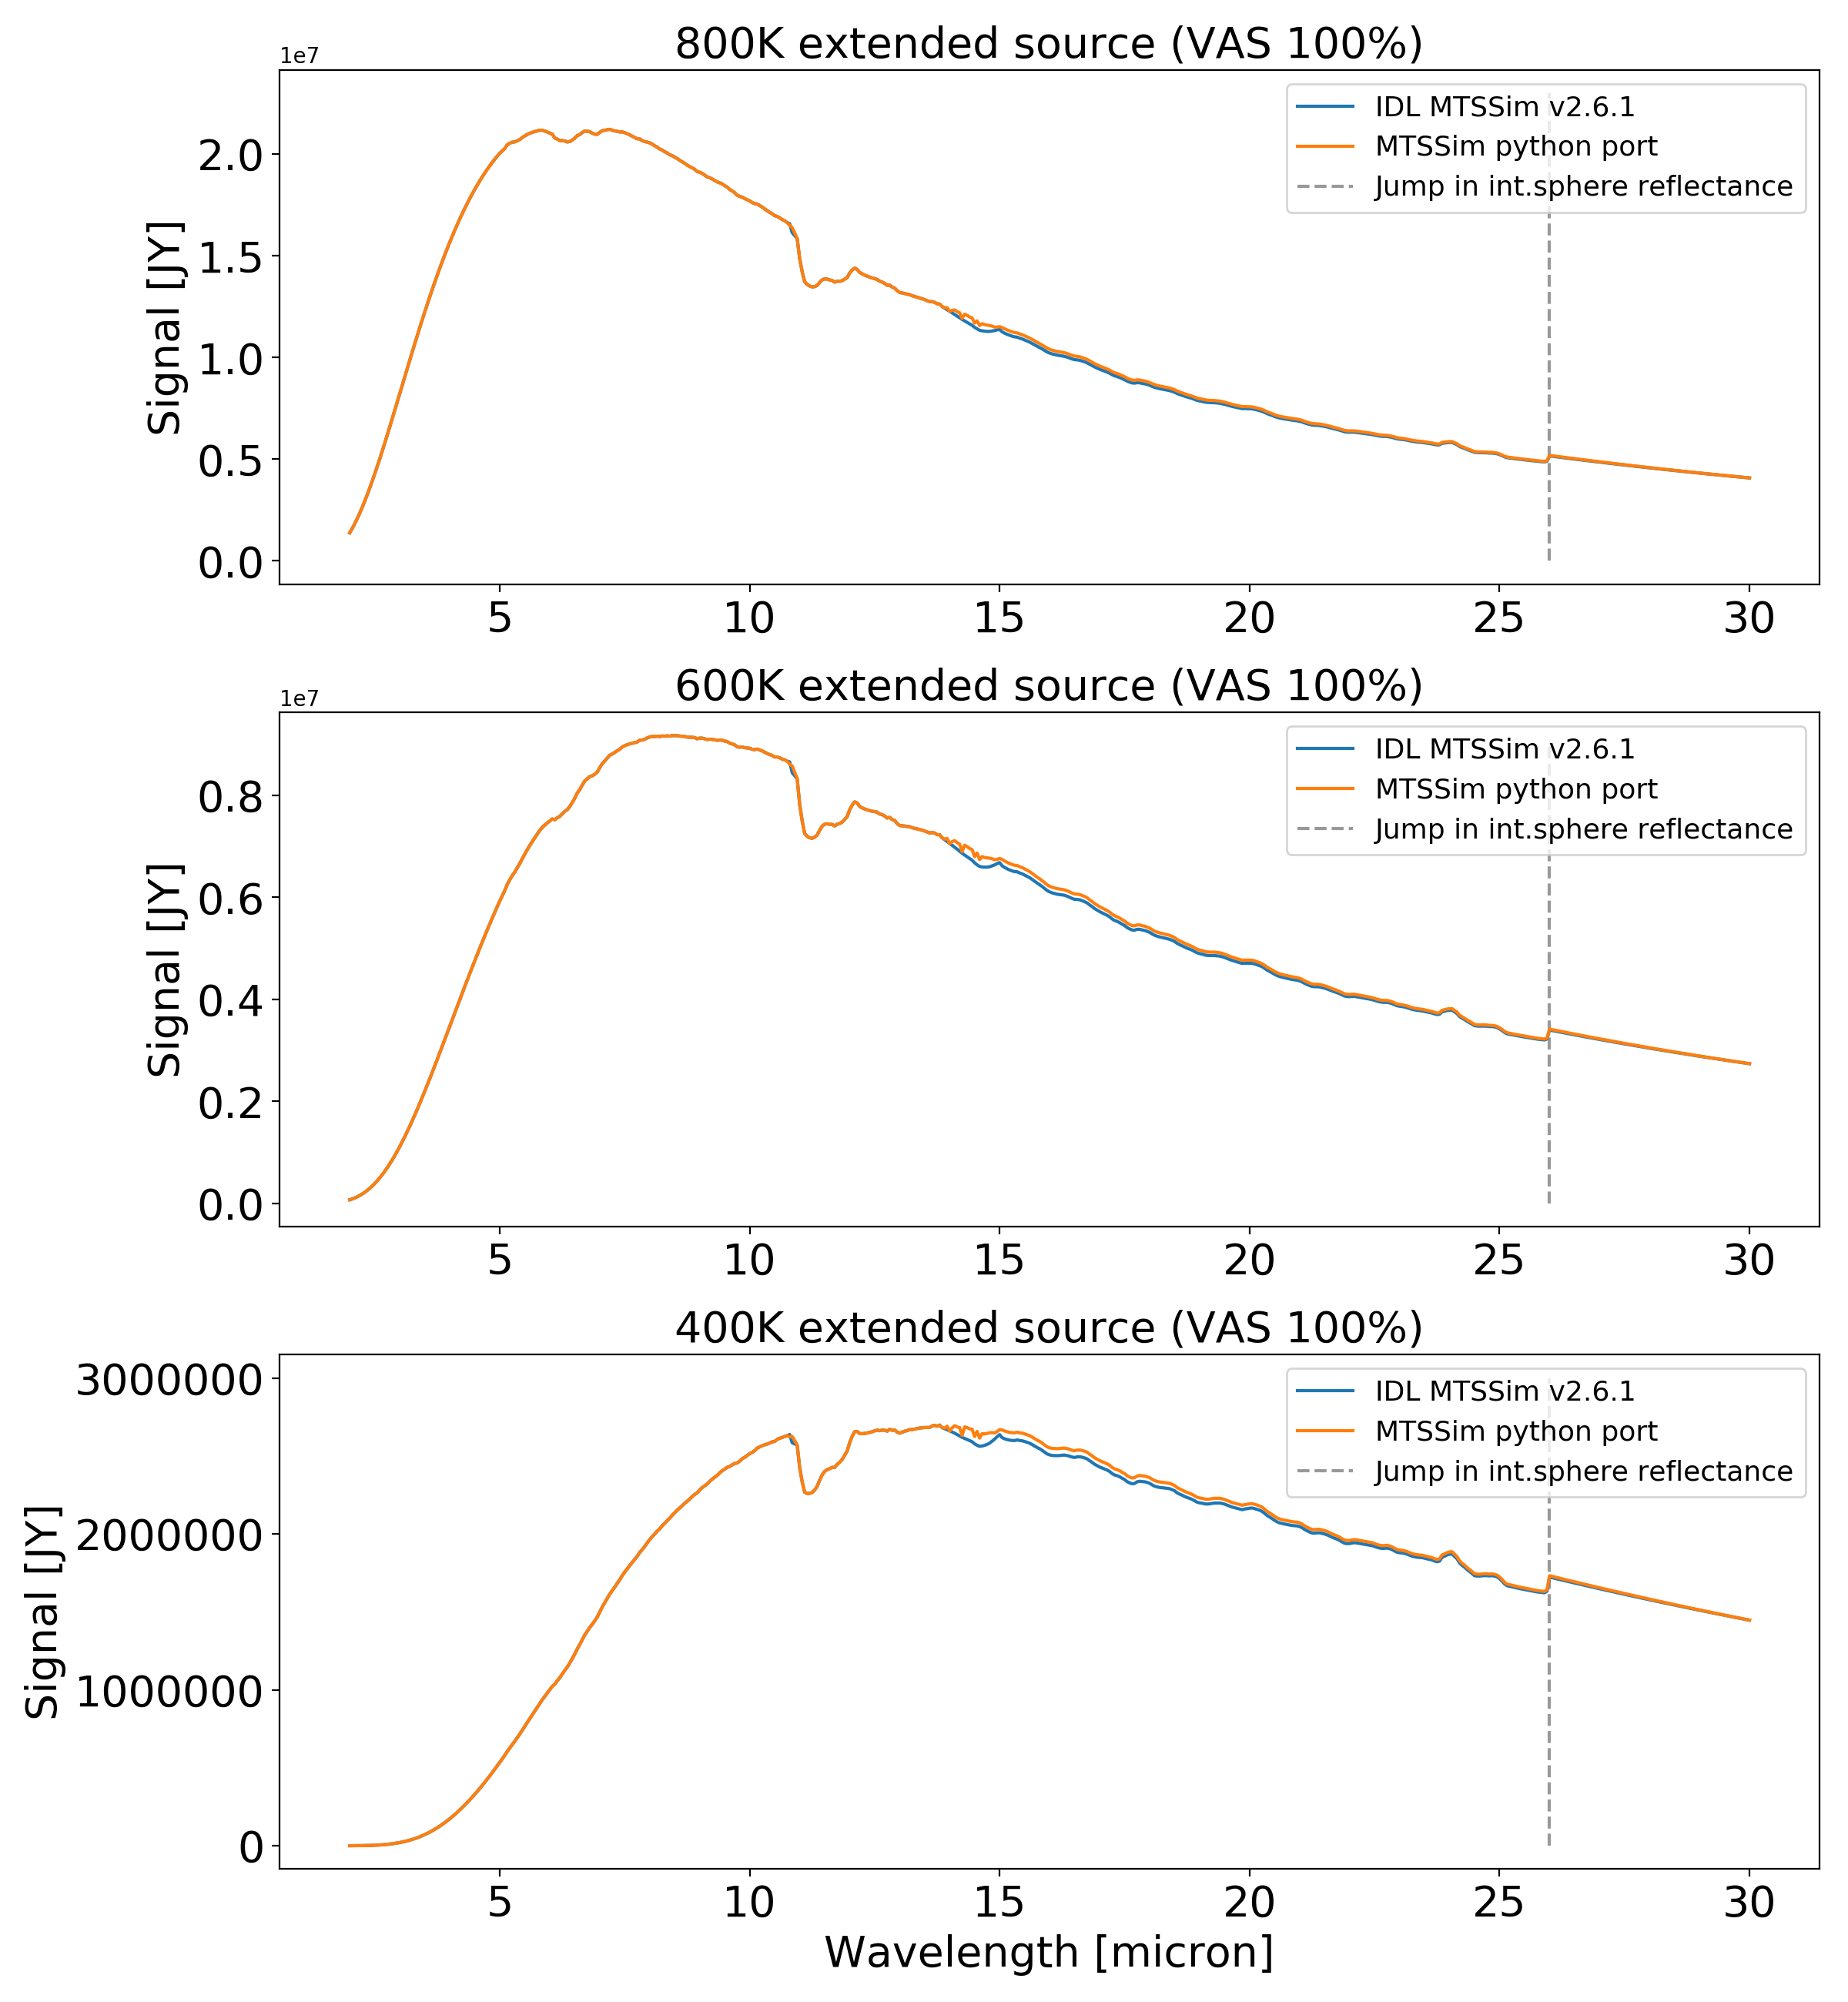

In [3]:
# make some comparative plots
import matplotlib.pyplot as plt
%matplotlib notebook

max_signal = [2.3E7,0.9E7,0.3E7]
fig,axs = plt.subplots(3,1,figsize=(12,13))
for plot,BB_Temp in enumerate(['800K','600K','400K']):
    axs[plot].set_title('{} extended source (VAS 100%)'.format(BB_Temp),fontsize=20)
    axs[plot].plot(MTSSim_wav,MTSSim_SED[BB_Temp],label='IDL MTSSim v2.6.1')
    axs[plot].plot(Vdata[BB_Temp]['wave'],Vdata[BB_Temp]['SPC'],label='MTSSim python port')
    axs[plot].vlines(26,0,max_signal[plot],linestyle='dashed',alpha=0.4,label='Jump in int.sphere reflectance')
    axs[plot].set_ylabel('Signal [{}]'.format(Vdata[BB_Temp]['units']),fontsize=20)
    axs[plot].legend(loc='upper right',fontsize=13)
    axs[plot].tick_params(axis='both',labelsize=20)
axs[2].set_xlabel('Wavelength [micron]',fontsize=20)
plt.tight_layout()

There appears to be a small difference between the python-ported output SED and the original IDL output SED. Let's plot the ratio of the two for the three test cases to see what is happening.

<IPython.core.display.Javascript object>


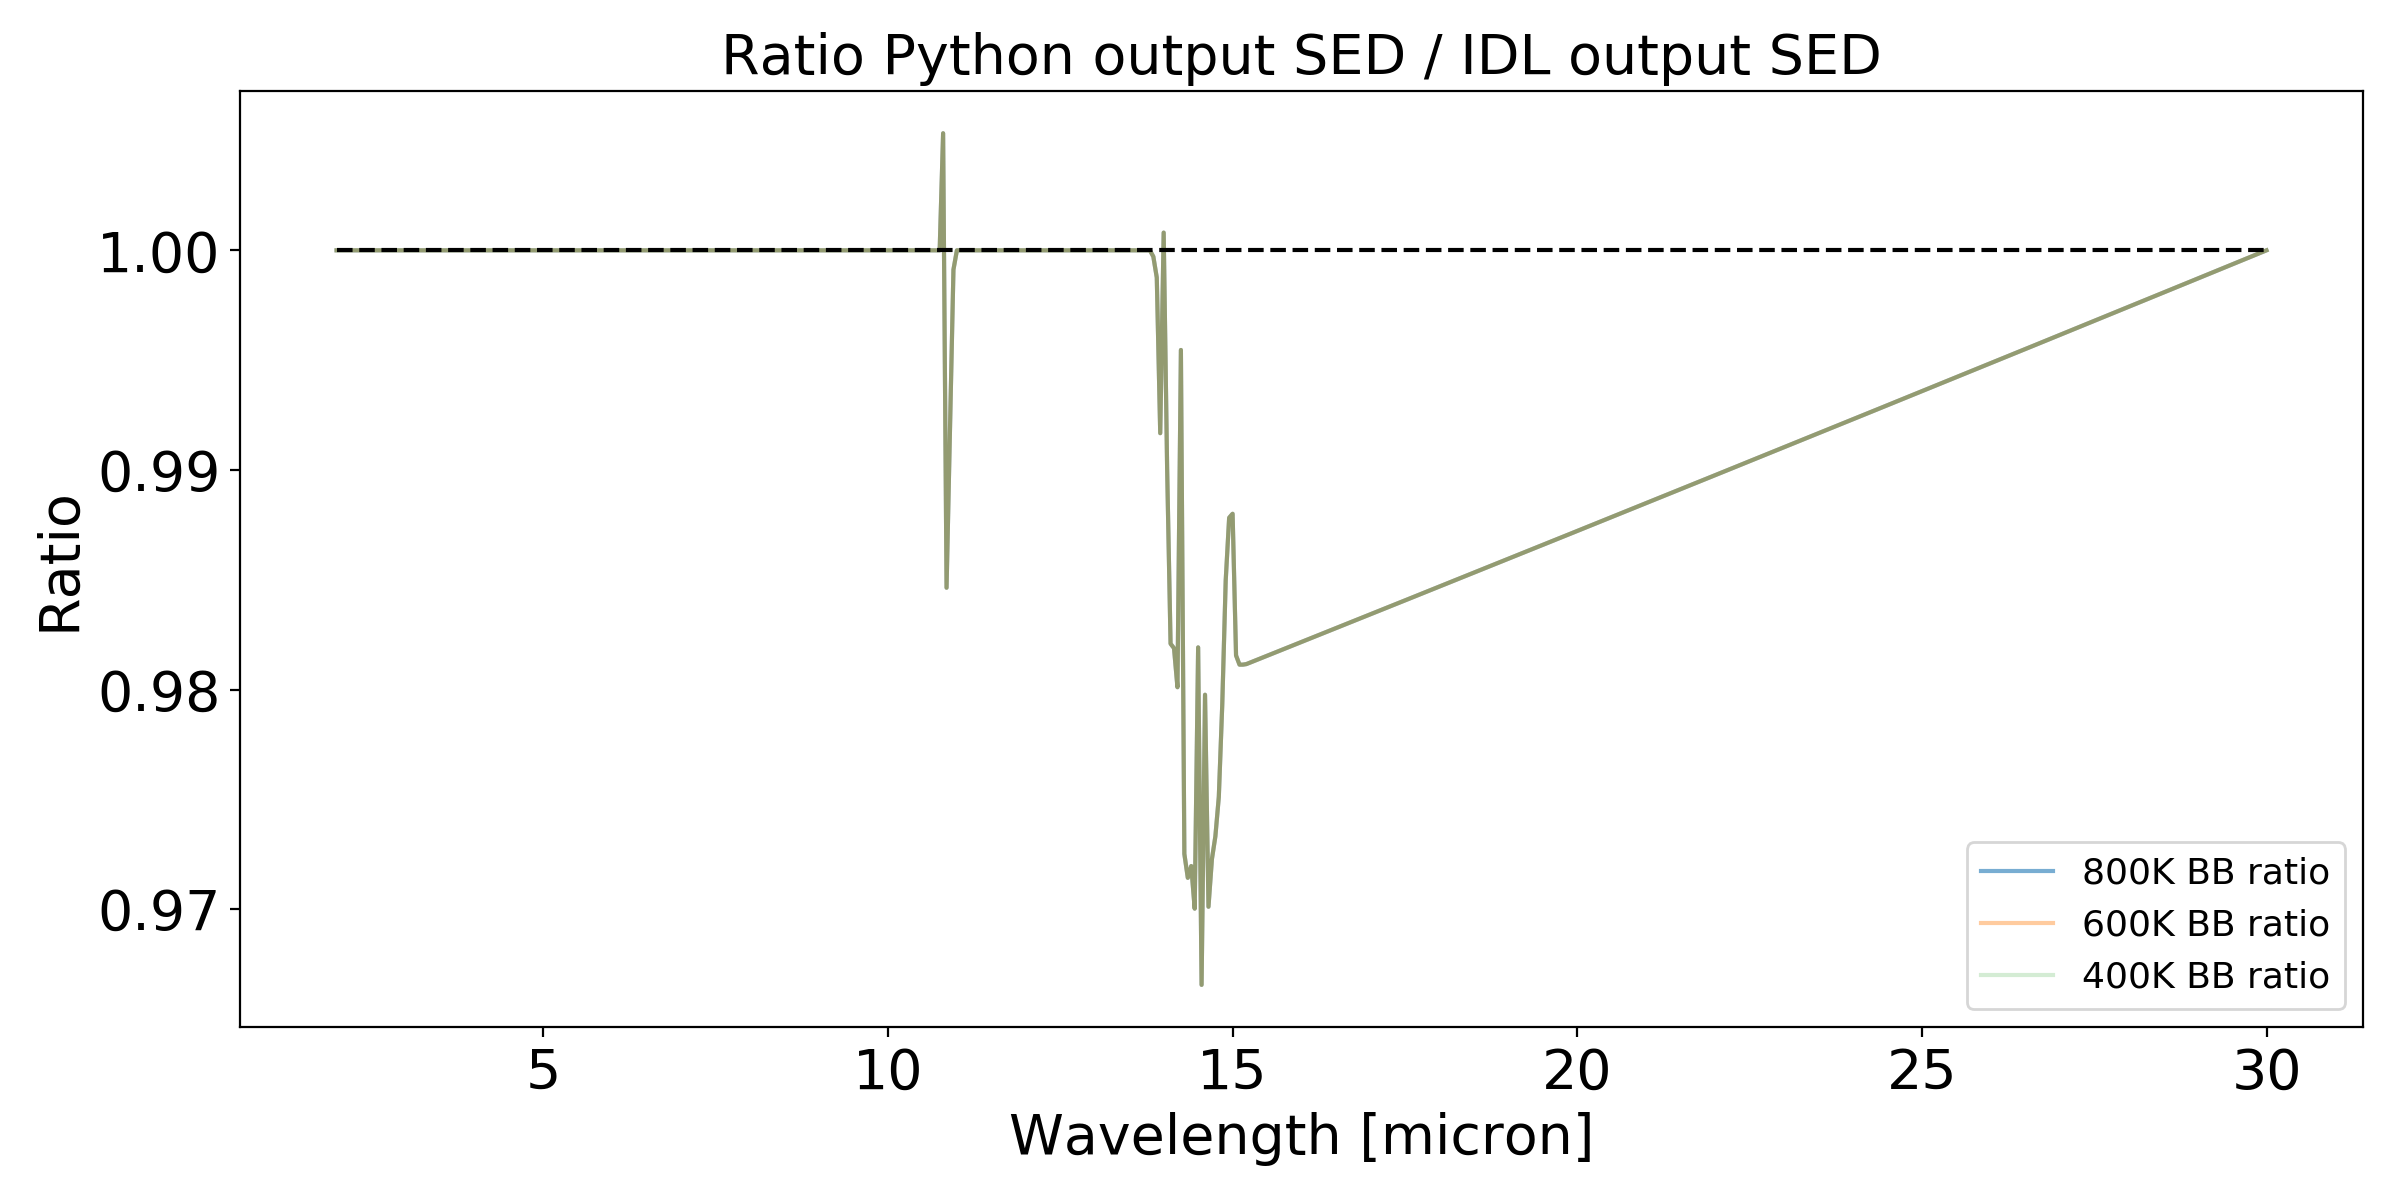

In [4]:
opacities = [0.6,0.4,0.2]
plt.figure(figsize=(12,6))
plt.title('Ratio Python output SED / IDL output SED',fontsize=20)
for plot,BB_Temp in enumerate(['800K','600K','400K']):
    plt.plot(Vdata[BB_Temp]['wave'],MTSSim_SED[BB_Temp]/Vdata[BB_Temp]['SPC'],alpha=opacities[plot],label='{} BB ratio'.format(BB_Temp),zorder=0)
plt.hlines(1,MTSSim_wav.min(),MTSSim_wav.max(),'k',linestyle='dashed',zorder=1)
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('Ratio',fontsize=20)
plt.legend(loc='lower right',fontsize=13)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

So,
* the ratio between the python-ported output SED and the IDL SED is the same for all three blackbody cases.
* The erratic-looking difference is actually caused by the handling (/interpolation) of the MTS MOS mirror transmission curve (stored in "MOStransmit.dat"). There is actually a discontinuity in the transmission data, which jump from 14.5 micron to 30 micron (i.e. there are no datapoints between these two edge wavelengths). The IDL/Python code handling of the discontinuity causes an initial deviation and subsequent slow convergence of the IDL output to the python-ported output.
* Given that a different transmission curve will be used from MTSSim v2.7 onwards ("MOScurve_capture_shift_blue0.06.txt" instead of "MOStransmit.dat", the former of which has a much better wavelength coverage), the above discrepancy between the IDL code and the python code is inconsequential.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

wav,transm = np.genfromtxt('/Users/ioannisa/Desktop/python/miri_devel/notebooks/MTSsim_python/TRANSMIT/MOStransmit.dat',usecols=(0,1),unpack=True)
wav2,transm2 = np.genfromtxt('/Users/ioannisa/Desktop/python/miri_devel/MTSSim_v2.6.1_pythonPort/TRANSMIT/FM.dat',usecols=(0,1),unpack=True)
# wav3,transm3 = np.genfromtxt('/Users/ioannisa/Desktop/python/miri_devel/MTSSim_v2.7beta_lite/TRANSMIT/ISgold.dat',usecols=(0,1),unpack=True)

## > Run simulation step-by-step

In [8]:
# inputs
T_BB = 800.
Usefilter = 'HOLE'
VASap = 100.
target = 'EXT'
MIRI='OFF'
pssON = None
parfile='inputs_test.txt'
INSTRUCT = None
FLUXES = None
plot = True

In [9]:
# modules
import numpy as np 

from internalvalues import stt
from set_up import SET_UP
from initialize import INITIALIZE
from bb import BB
from col import COL
from vas import VAS
from fw import FW
from etalons import ETALONS
from integrsphere import IS
from sss import SSS
from mos import MOS
from fpss import fPSS
from fms import FMs
from oba import OBA
from pom import POM
from addup_bkg import ADDUP_BKG
from _convert import _CONVERT

import matplotlib.pyplot as plt
%matplotlib notebook

In [10]:
# START
config = SET_UP(T_BB, Usefilter, VASap, target, stt, pssON=pssON,MIRI=MIRI, parfile=parfile)

# INITIALIZE the main data structure
# which holds the spectral vectors: Vdata

Vdata = INITIALIZE(config, stt)

<IPython.core.display.Javascript object>


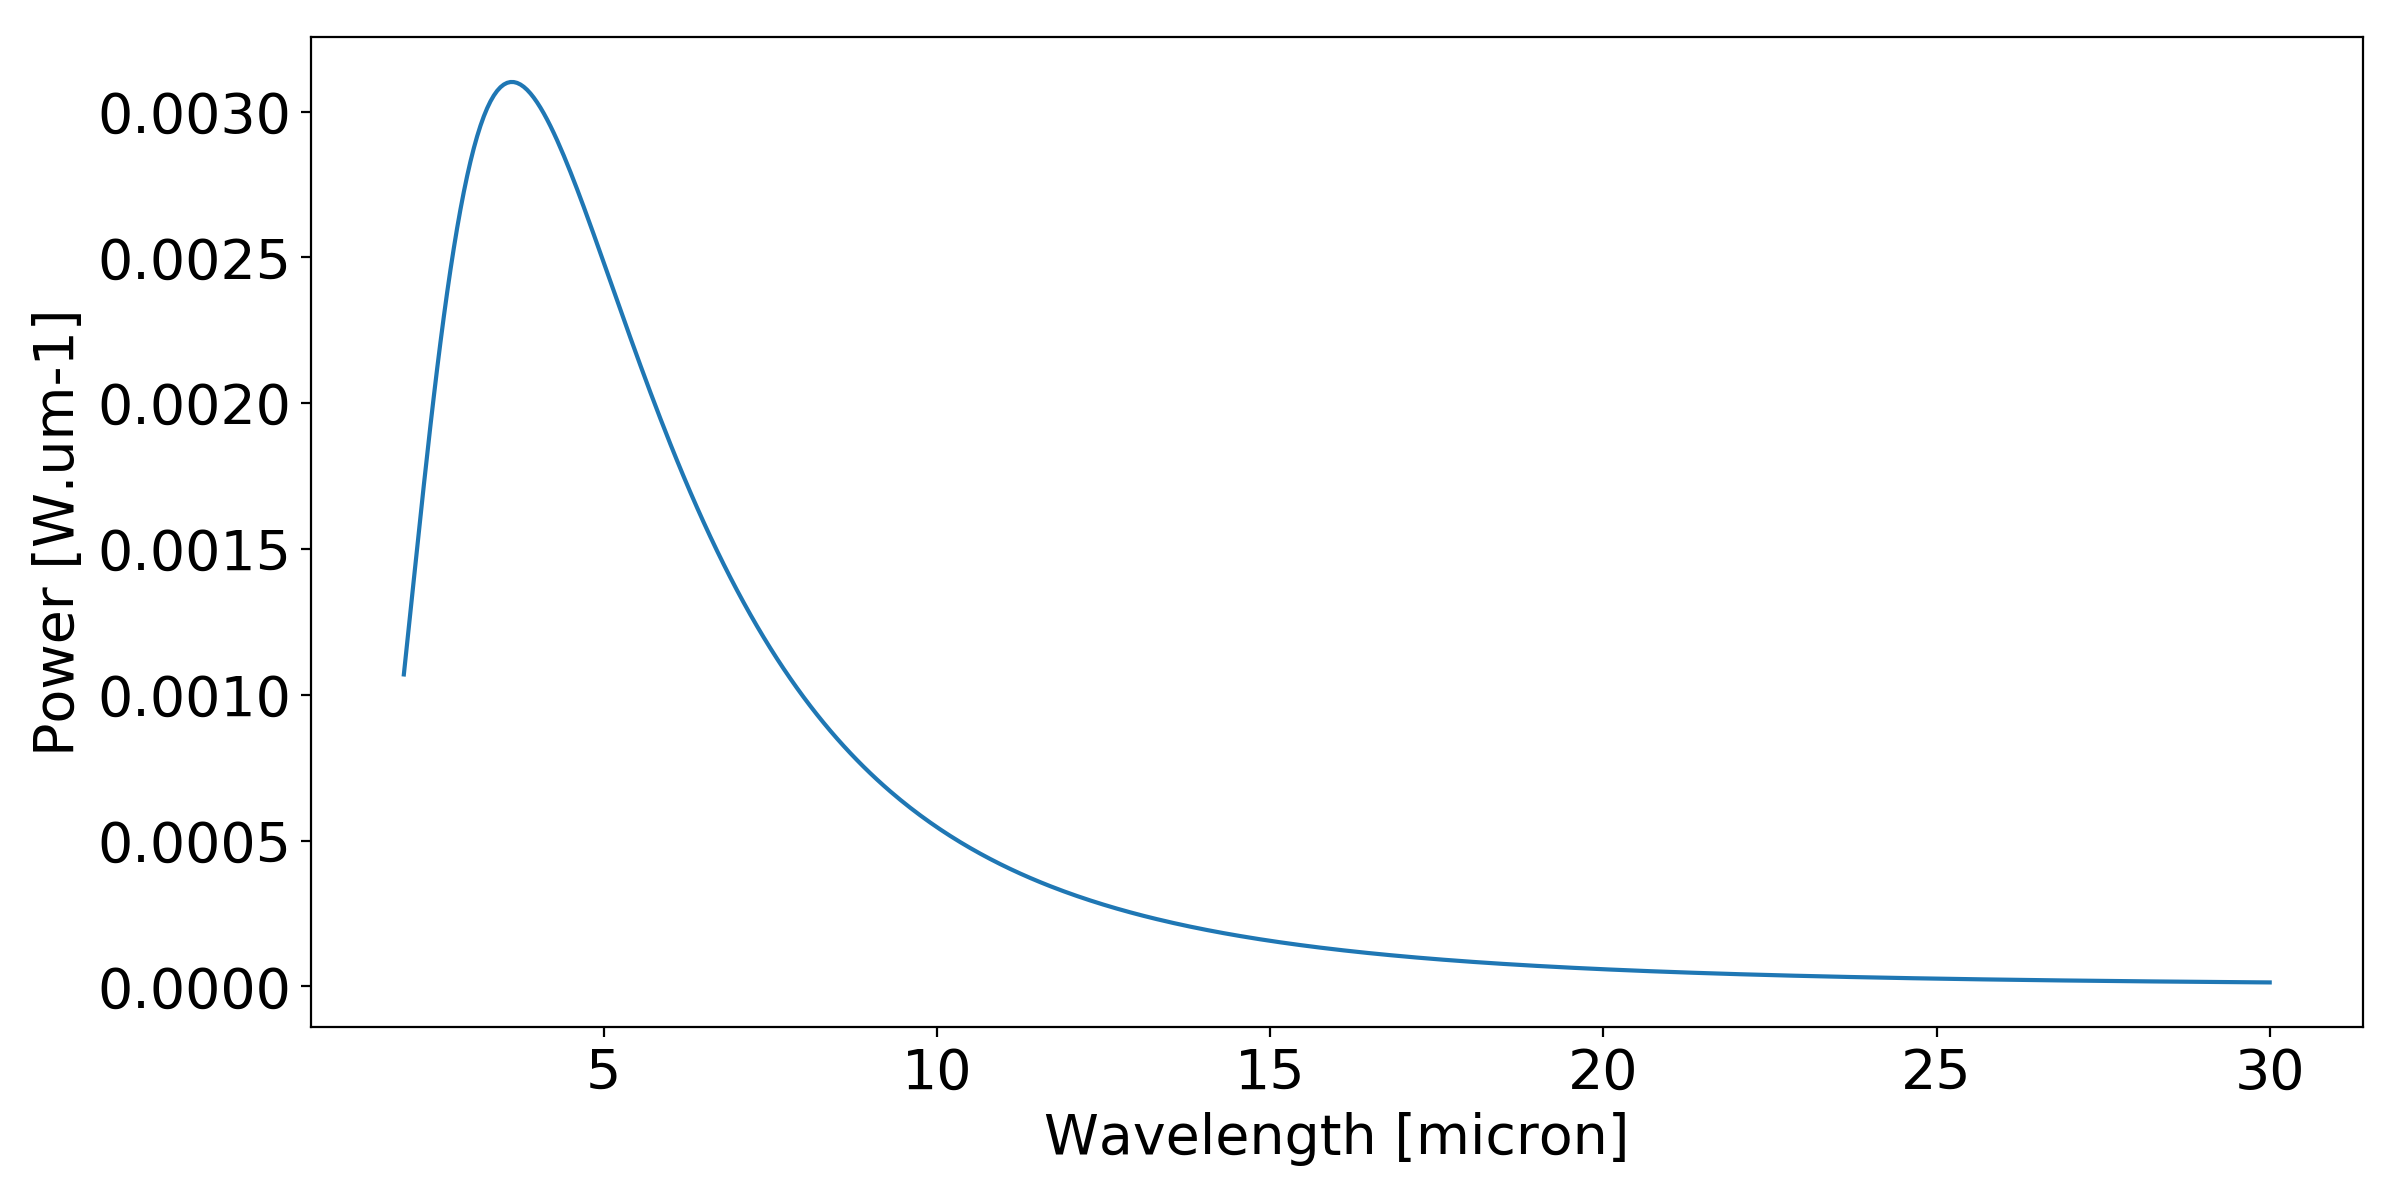

In [12]:
# BB

Vdata = BB(Vdata, config, stt) # P, [W um-1]
Vdata_BB = Vdata['SPC'].copy()

if plot:
    plt.figure(figsize=(12,6))
    plt.plot(Vdata['wave'],Vdata_BB)
    plt.xlabel('Wavelength [micron]',fontsize=20)
    plt.ylabel('Power [W.um-1]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

<IPython.core.display.Javascript object>


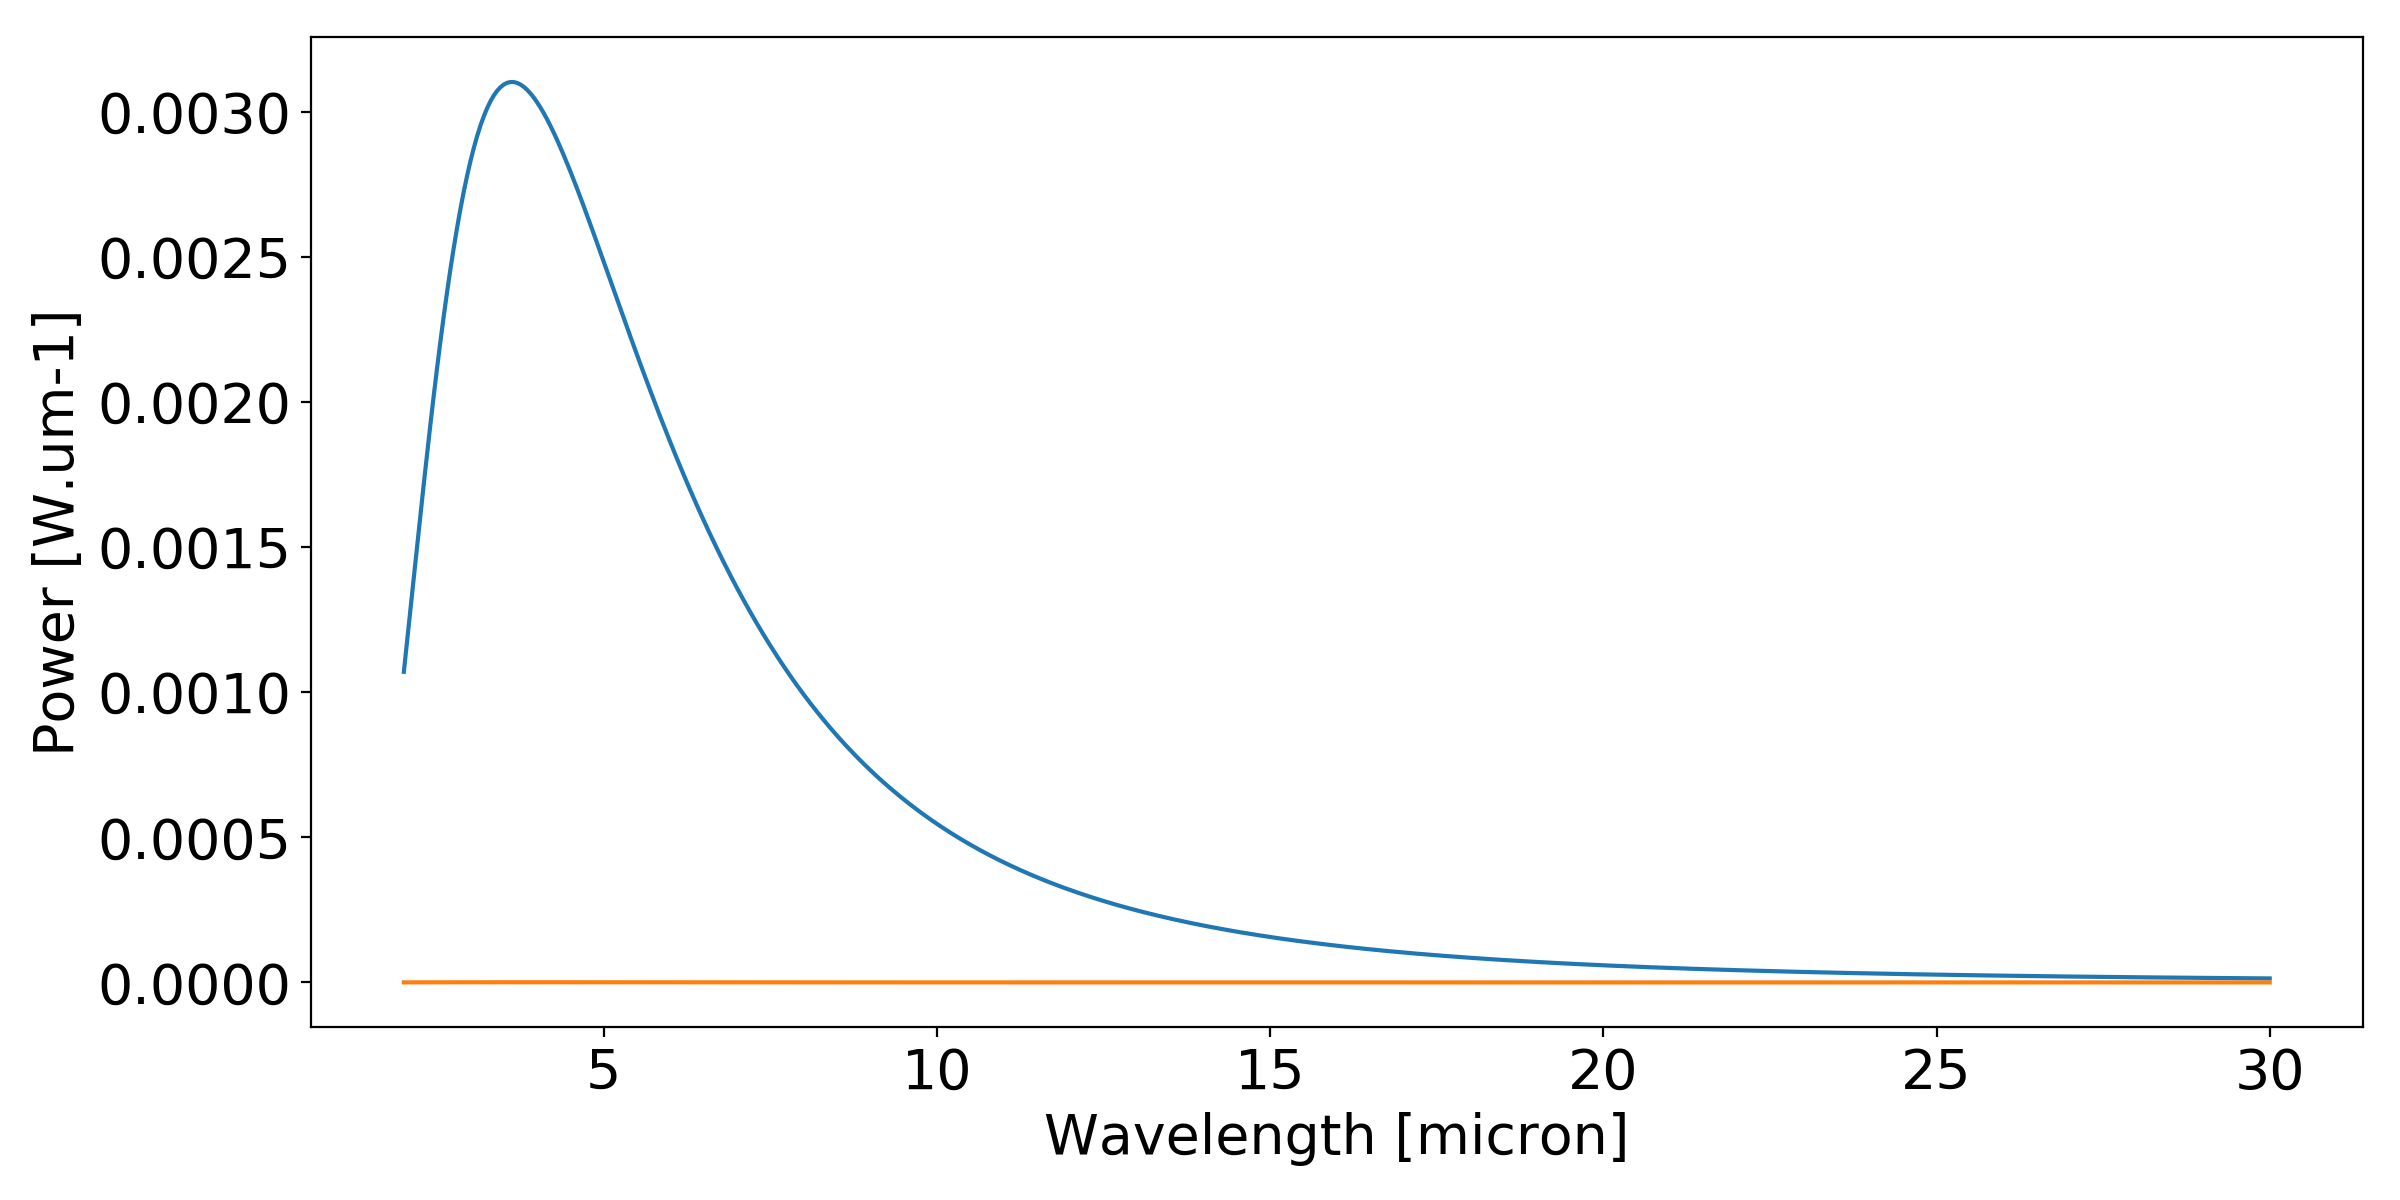

In [14]:
# COLLIMATOR

Vdata = COL(Vdata, config, stt)
Vdata_COL = Vdata['SPC'].copy()

if plot:
    plt.figure(figsize=(12,6))
    plt.plot(Vdata['wave'],Vdata_BB)
    plt.plot(Vdata['wave'],Vdata_COL)
    plt.xlabel('Wavelength [micron]',fontsize=20)
    plt.ylabel('Power [W.um-1]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

<IPython.core.display.Javascript object>


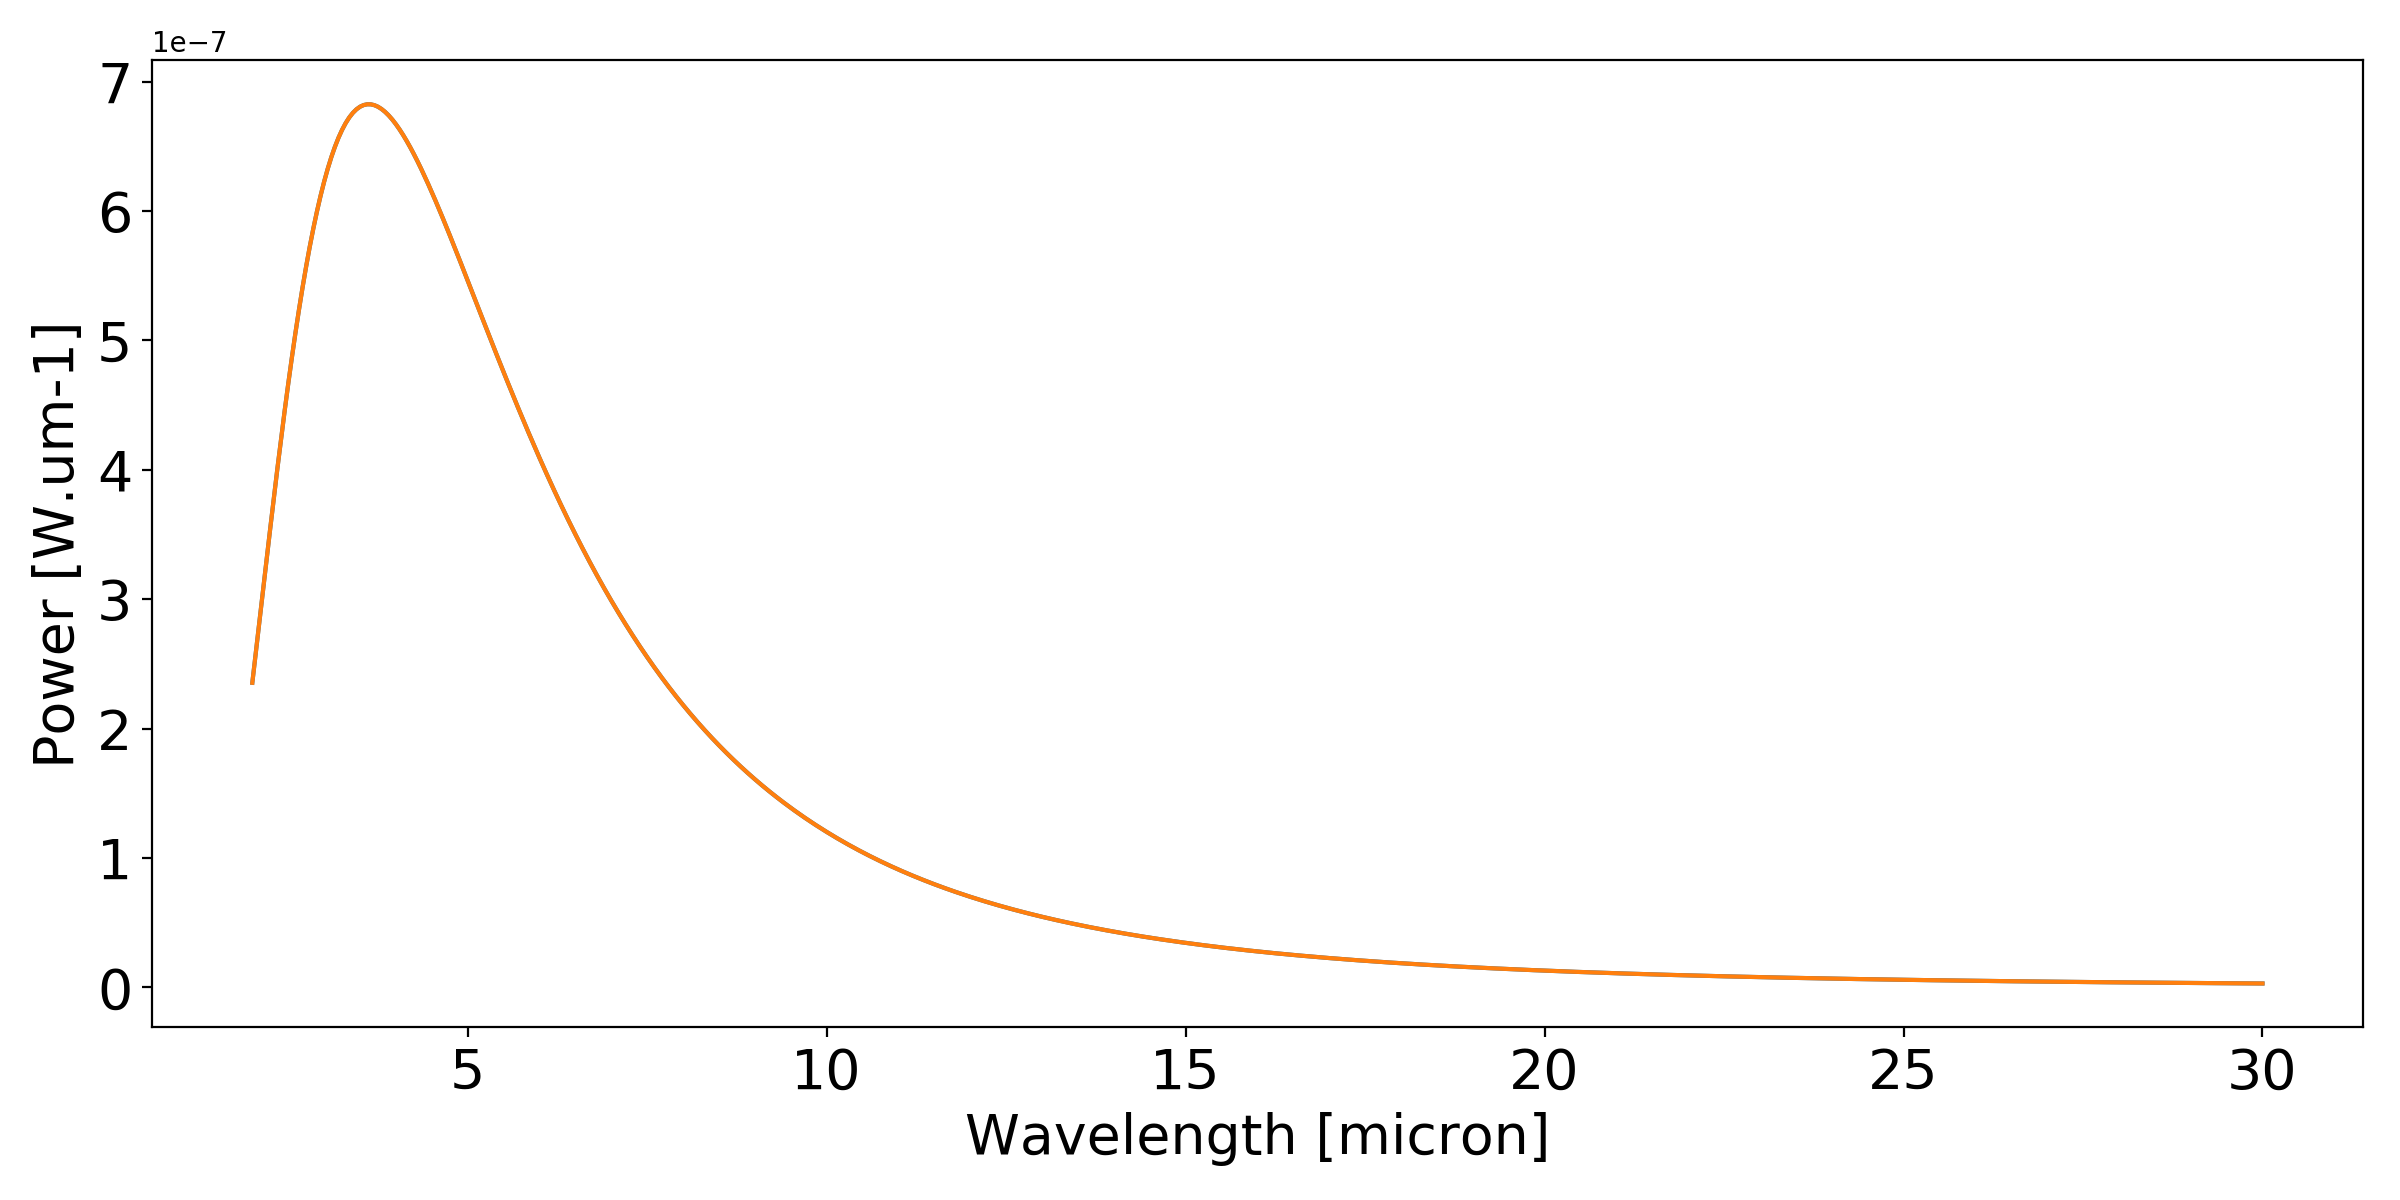

In [15]:
# VAS

Vdata = VAS(Vdata, config, stt)
Vdata_VAS = Vdata['SPC'].copy()

if plot:
    plt.figure(figsize=(12,6))
    plt.plot(Vdata['wave'],Vdata_COL)
    plt.plot(Vdata['wave'],Vdata_VAS)
    plt.xlabel('Wavelength [micron]',fontsize=20)
    plt.ylabel('Power [W.um-1]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

<IPython.core.display.Javascript object>


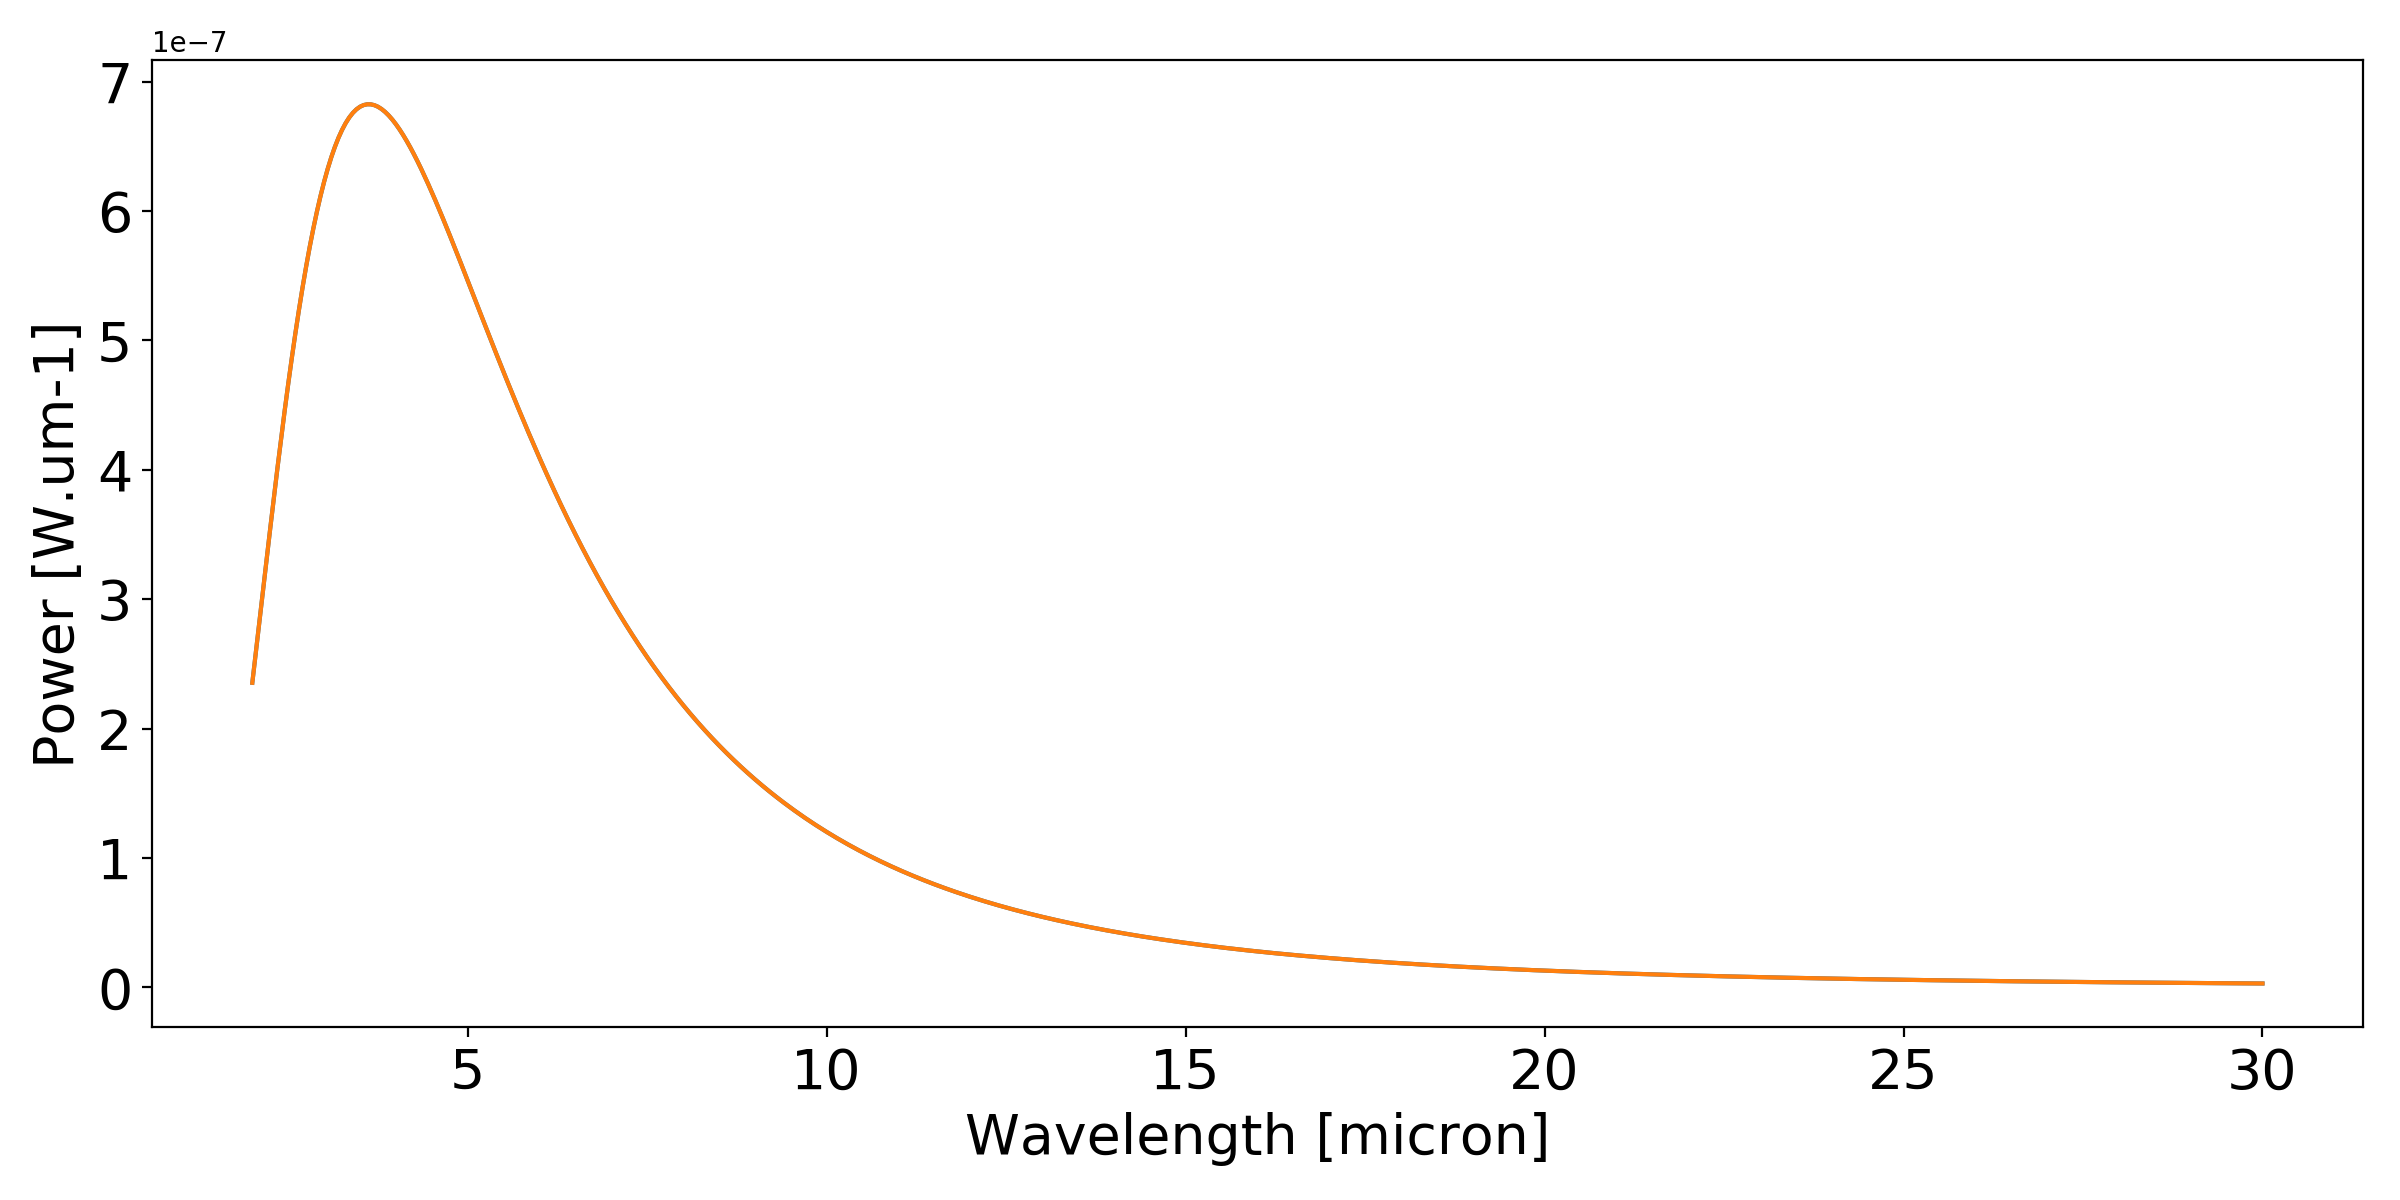

In [16]:
# FILTER WHEEL (Etalons are worked out apart,
# given that their calculations are far more involved).

if config['EtalonON'] == stt['False']:  Vdata = FW(Vdata, config, stt)
Vdata_FW = Vdata['SPC'].copy()

if plot:
    plt.figure(figsize=(12,6))
    plt.plot(Vdata['wave'],Vdata_VAS)
    plt.plot(Vdata['wave'],Vdata_FW)
    plt.xlabel('Wavelength [micron]',fontsize=20)
    plt.ylabel('Power [W.um-1]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

<IPython.core.display.Javascript object>


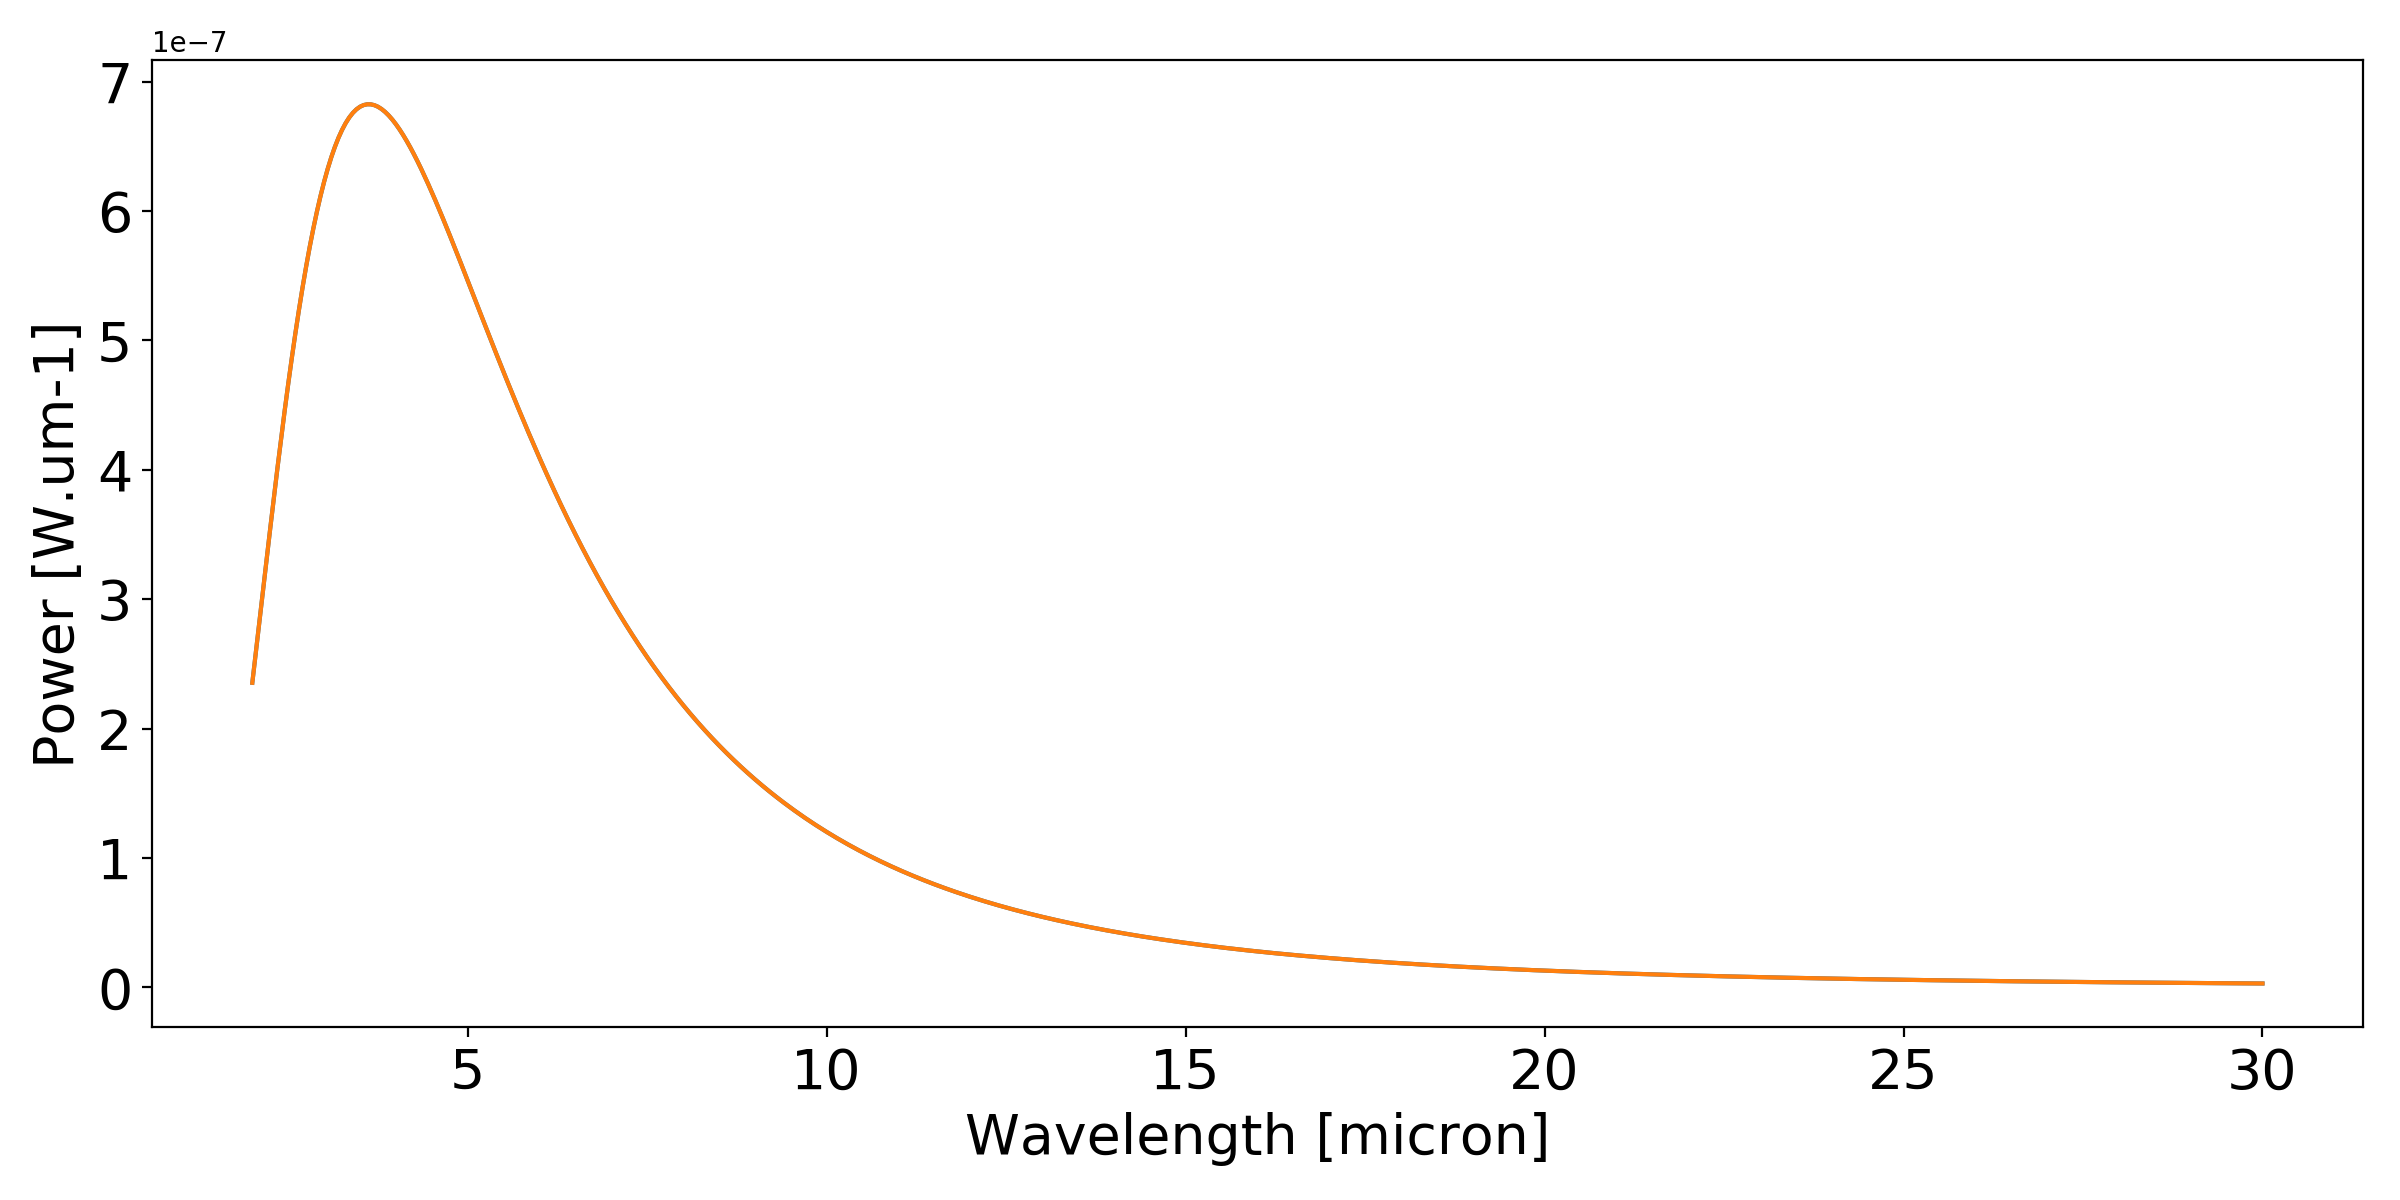

In [17]:
# ETALONs

if config['EtalonON'] == stt['True']:  Vdata = ETALONS(Vdata, config, stt)
Vdata_ETALONS = Vdata['SPC'].copy()

if plot:
    plt.figure(figsize=(12,6))
    plt.plot(Vdata['wave'],Vdata_FW)
    plt.plot(Vdata['wave'],Vdata_ETALONS)
    plt.xlabel('Wavelength [micron]',fontsize=20)
    plt.ylabel('Power [W.um-1]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

<IPython.core.display.Javascript object>


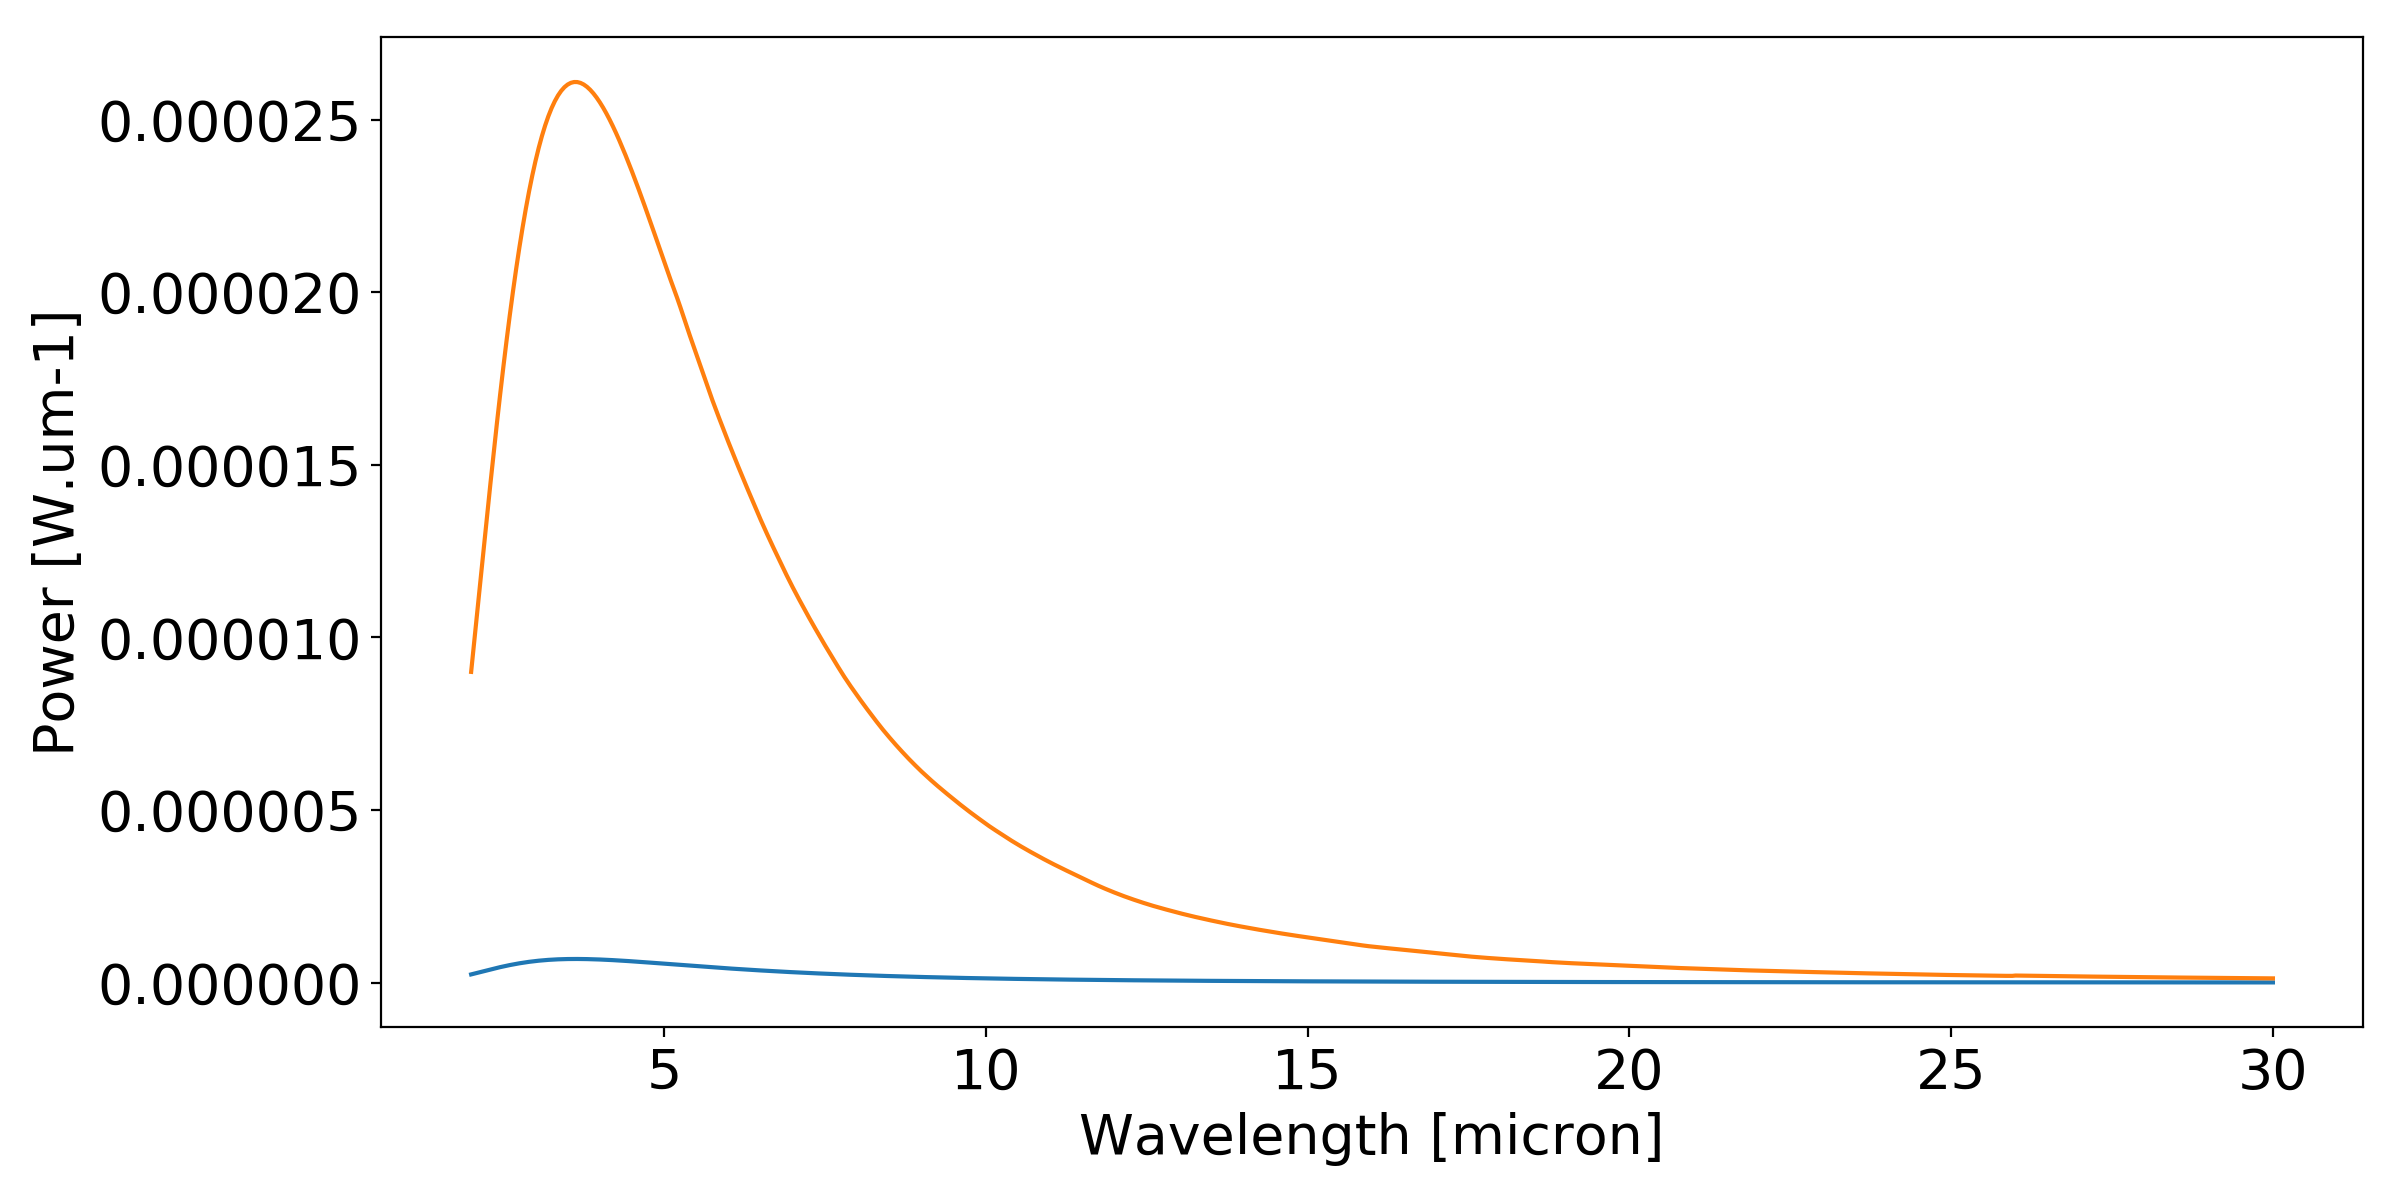

In [18]:
# IS

Vdata = IS(Vdata, config, stt)
Vdata_IS = Vdata['SPC'].copy()

if plot:
    plt.figure(figsize=(12,6))
    plt.plot(Vdata['wave'],Vdata_ETALONS)
    plt.plot(Vdata['wave'],Vdata_IS)
    plt.xlabel('Wavelength [micron]',fontsize=20)
    plt.ylabel('Power [W.um-1]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

<IPython.core.display.Javascript object>


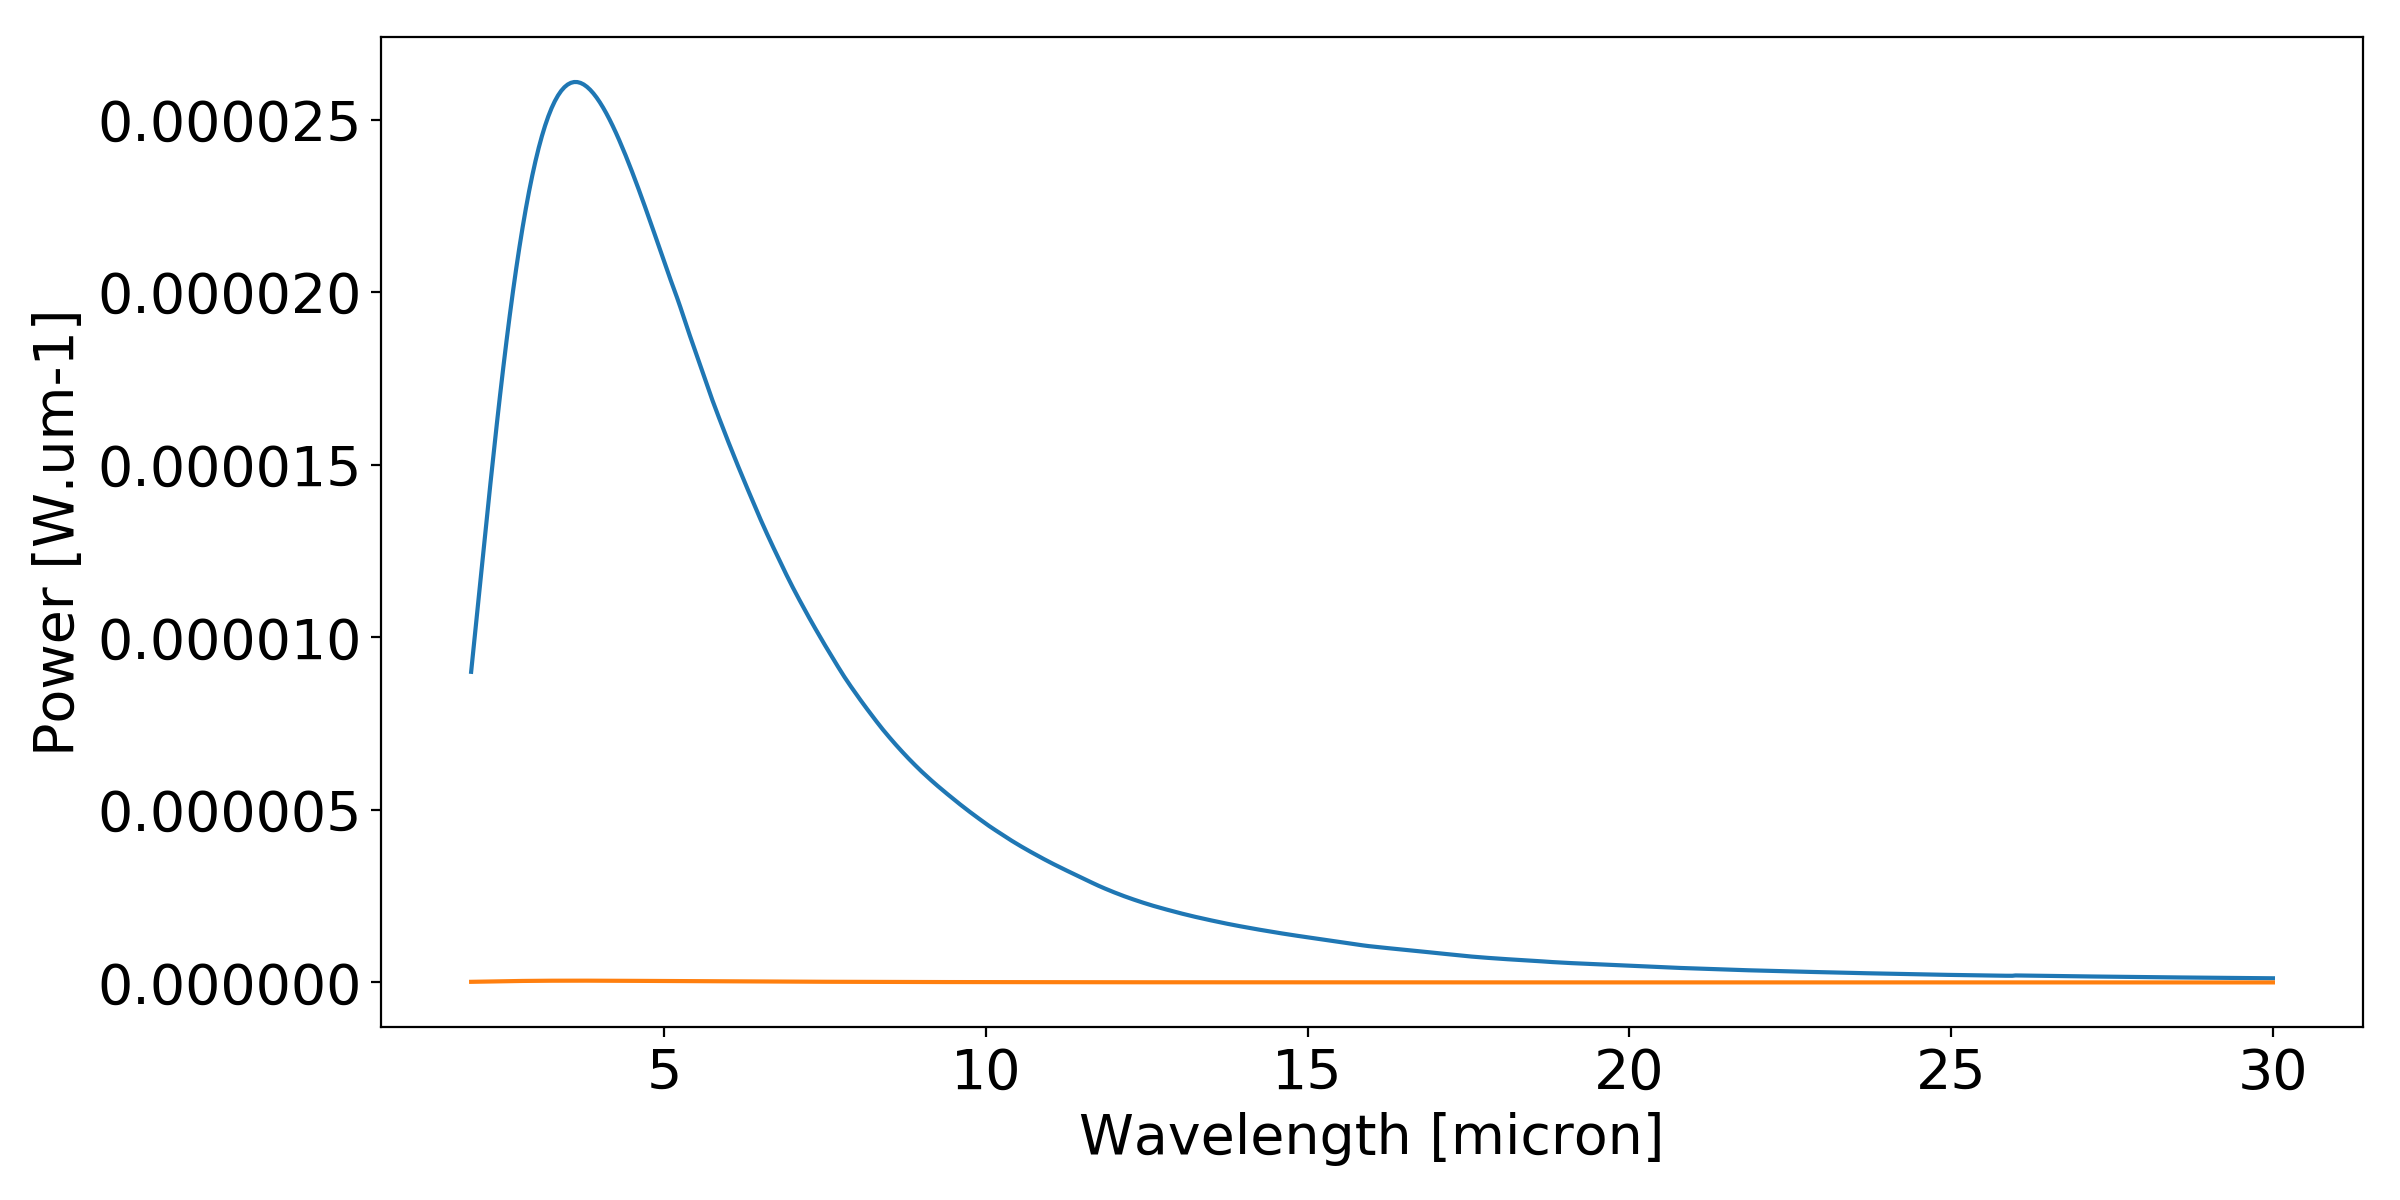

In [20]:
# SSS

Vdata = SSS(Vdata, config, stt)
Vdata_SSS = Vdata['SPC'].copy()

if plot:
    plt.figure(figsize=(12,6))
    plt.plot(Vdata['wave'],Vdata_IS)
    plt.plot(Vdata['wave'],Vdata_SSS)
    plt.xlabel('Wavelength [micron]',fontsize=20)
    plt.ylabel('Power [W.um-1]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

<IPython.core.display.Javascript object>


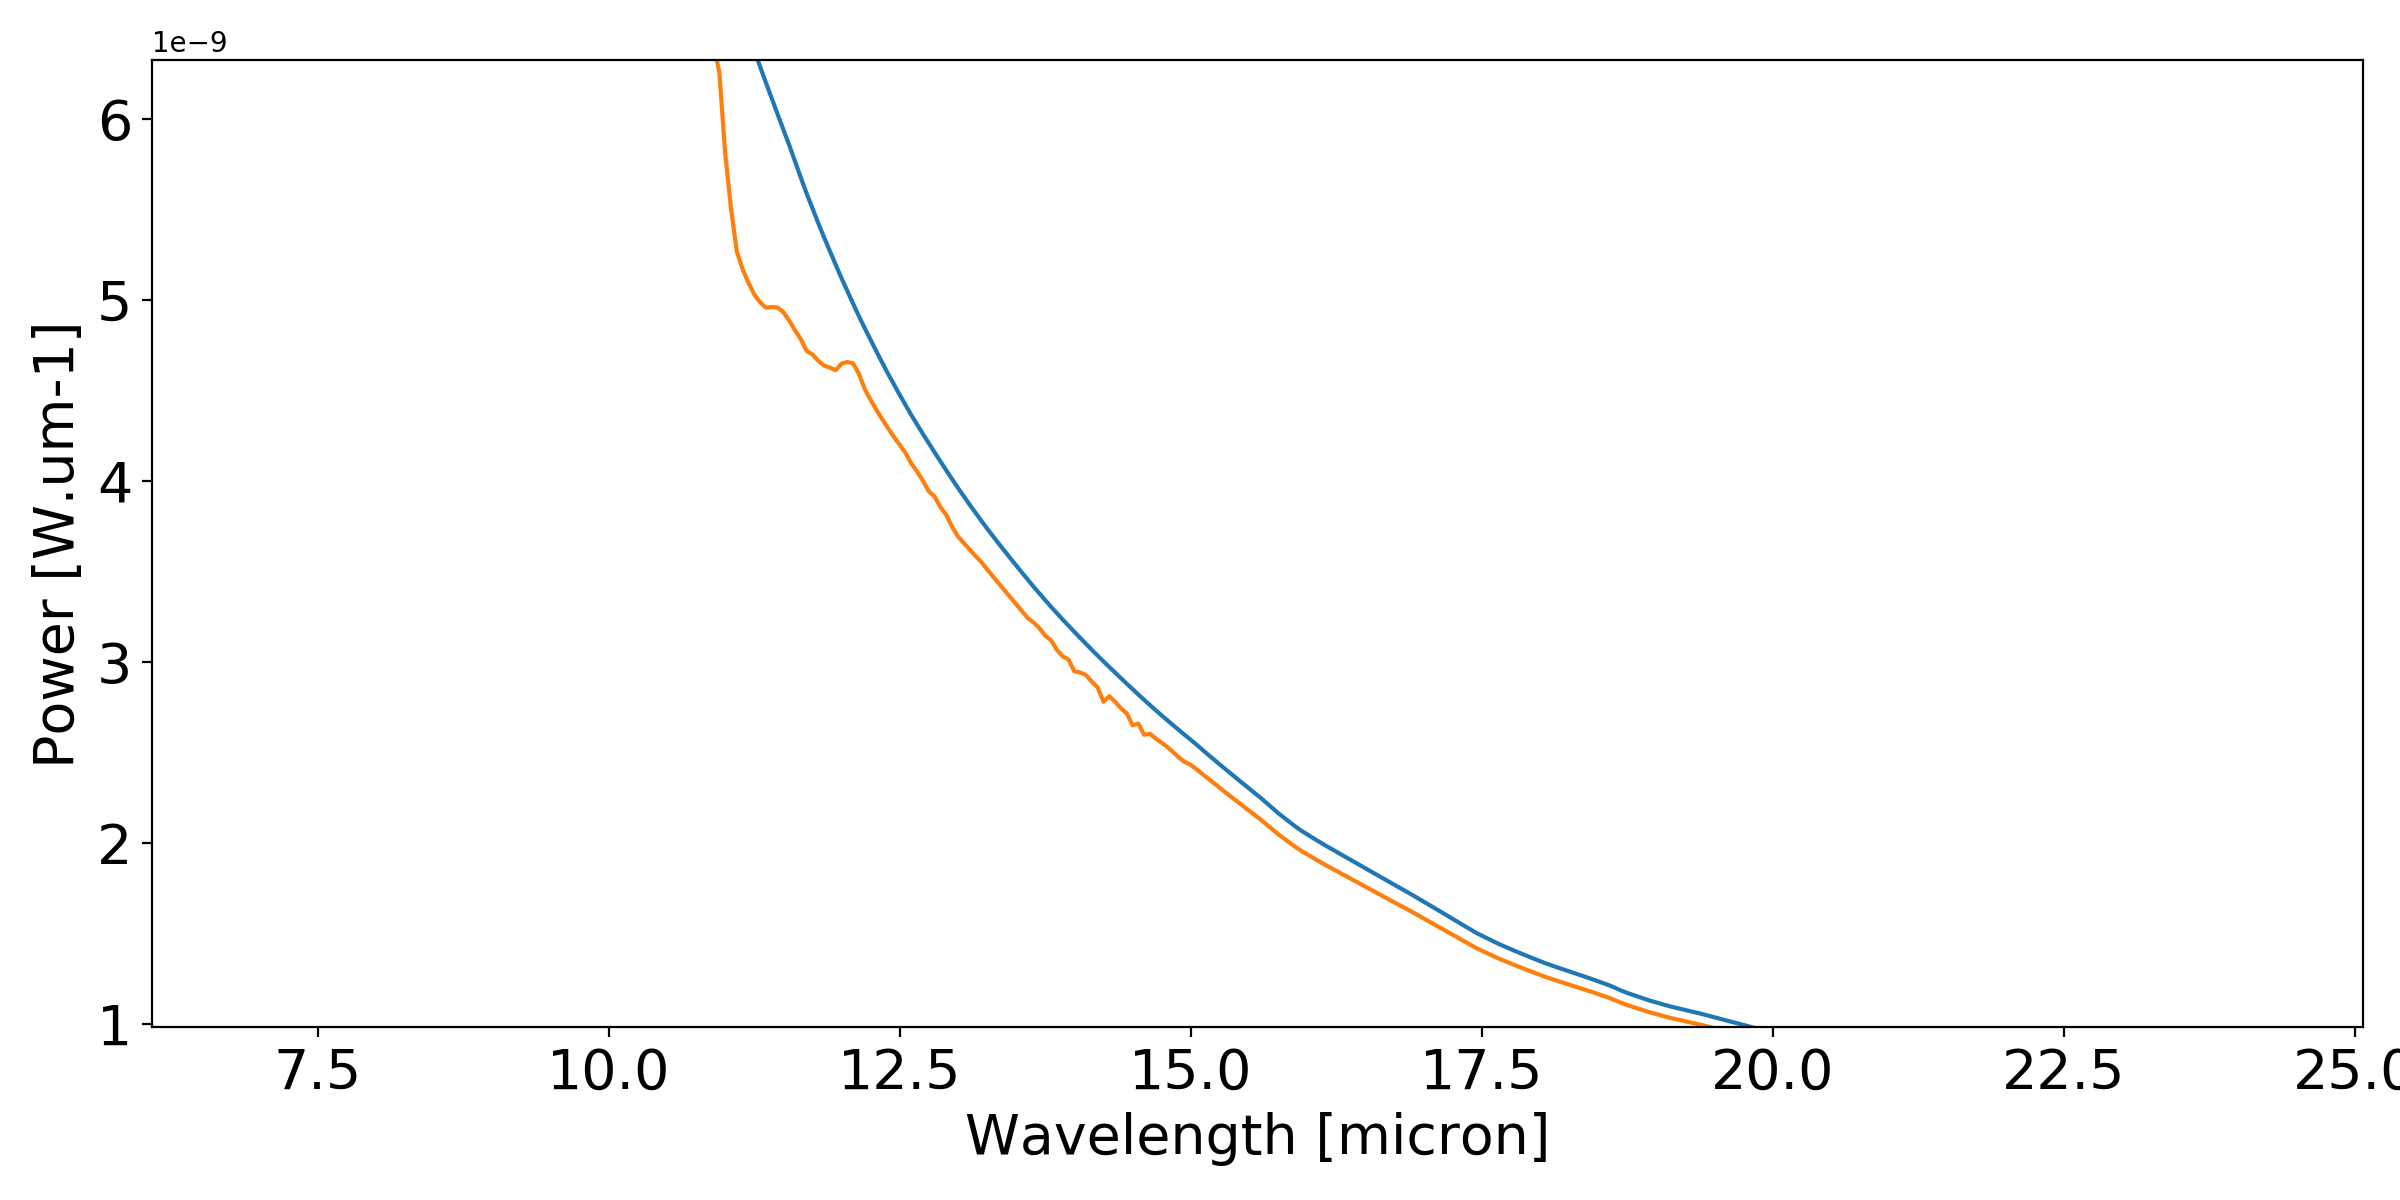

In [21]:
# MOS

Vdata = MOS(Vdata, config, stt)
Vdata_MOS = Vdata['SPC'].copy()

if plot:
    plt.figure(figsize=(12,6))
    plt.plot(Vdata['wave'],Vdata_SSS)
    plt.plot(Vdata['wave'],Vdata_MOS)
    plt.xlabel('Wavelength [micron]',fontsize=20)
    plt.ylabel('Power [W.um-1]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

In [22]:
# PSS

if config['pssON'] == stt['True']:  
    Vdata = fPSS(Vdata, config, stt)
    Vdata_fPSS = Vdata['SPC'].copy()

    if plot:
        plt.figure(figsize=(12,6))
        plt.plot(Vdata['wave'],Vdata_MOS)
        plt.plot(Vdata['wave'],Vdata_fPSS)
        plt.xlabel('Wavelength [micron]',fontsize=20)
        plt.ylabel('Power [W.um-1]',fontsize=20)
        plt.tick_params(axis='both',labelsize=20)
        plt.tight_layout()

<IPython.core.display.Javascript object>


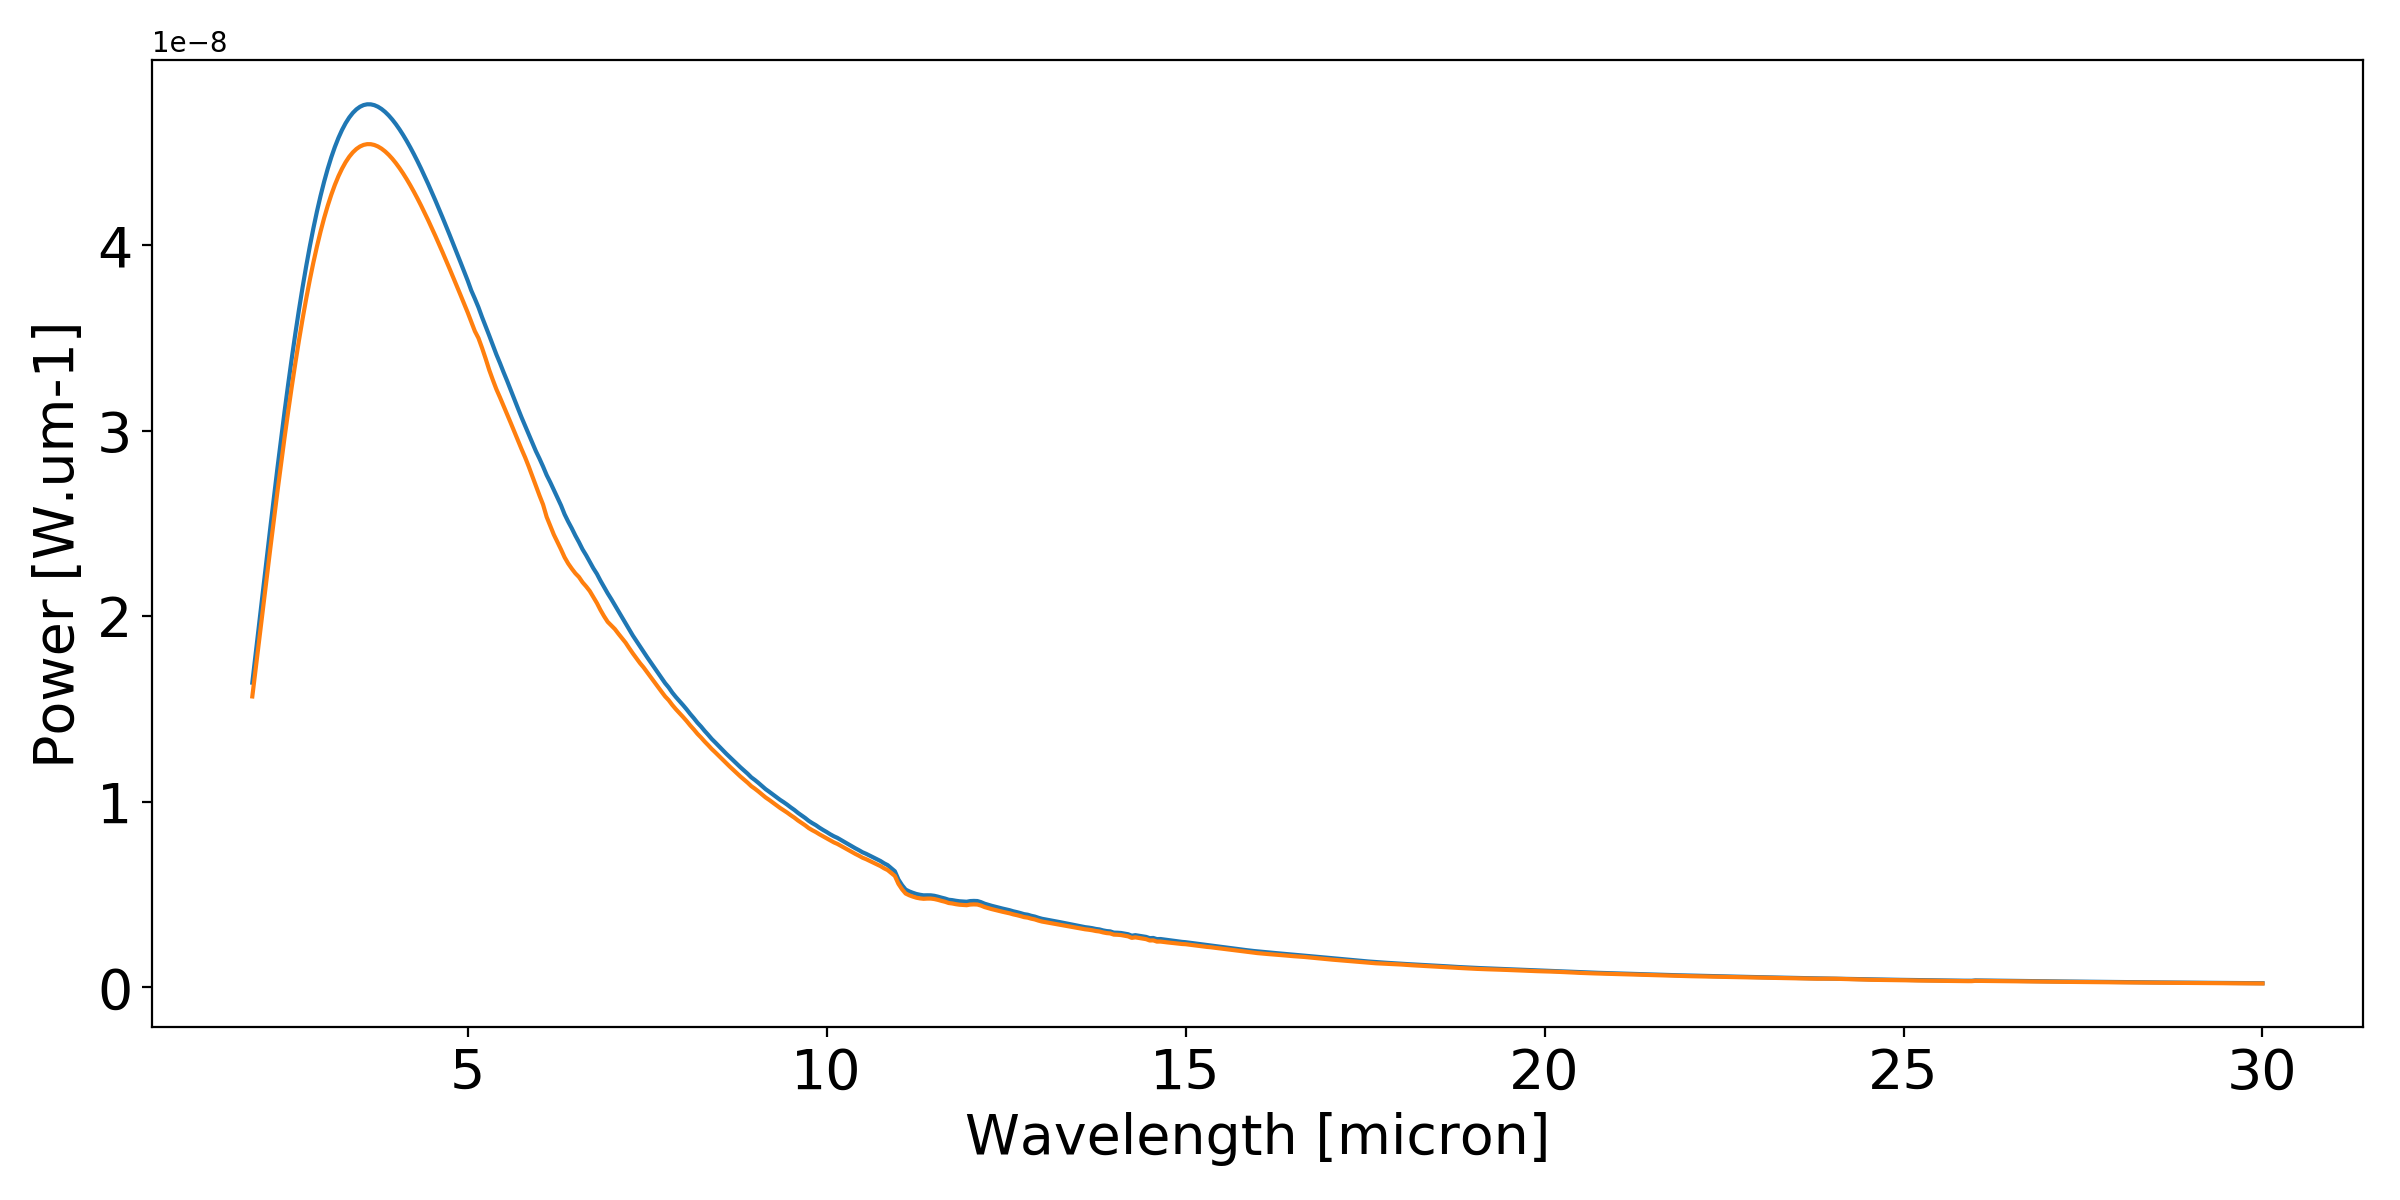

In [23]:
# FMs

Vdata = FMs(Vdata, config, stt)
Vdata_FMs = Vdata['SPC'].copy()

if plot:
    plt.figure(figsize=(12,6))
    plt.plot(Vdata['wave'],Vdata_MOS)
    plt.plot(Vdata['wave'],Vdata_FMs)
    plt.xlabel('Wavelength [micron]',fontsize=20)
    plt.ylabel('Power [W.um-1]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

<IPython.core.display.Javascript object>


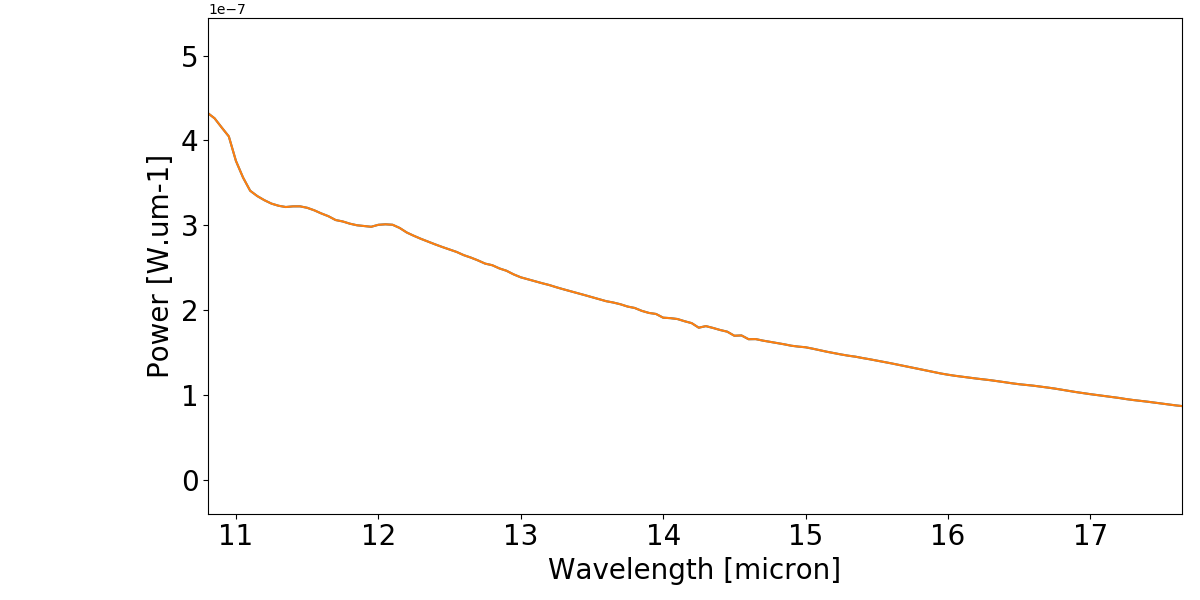

In [25]:
# OBA

Vdata = OBA(Vdata, stt)
Vdata_OBA = Vdata.copy()

if plot:
    plt.figure(figsize=(12,6))
    plt.plot(Vdata_FMs['wave'],Vdata_FMs['SPC'])
    plt.plot(Vdata_OBA['wave'],Vdata_OBA['SPC'])
    plt.xlabel('Wavelength [micron]',fontsize=20)
    plt.ylabel('Power [W.um-1]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

<IPython.core.display.Javascript object>


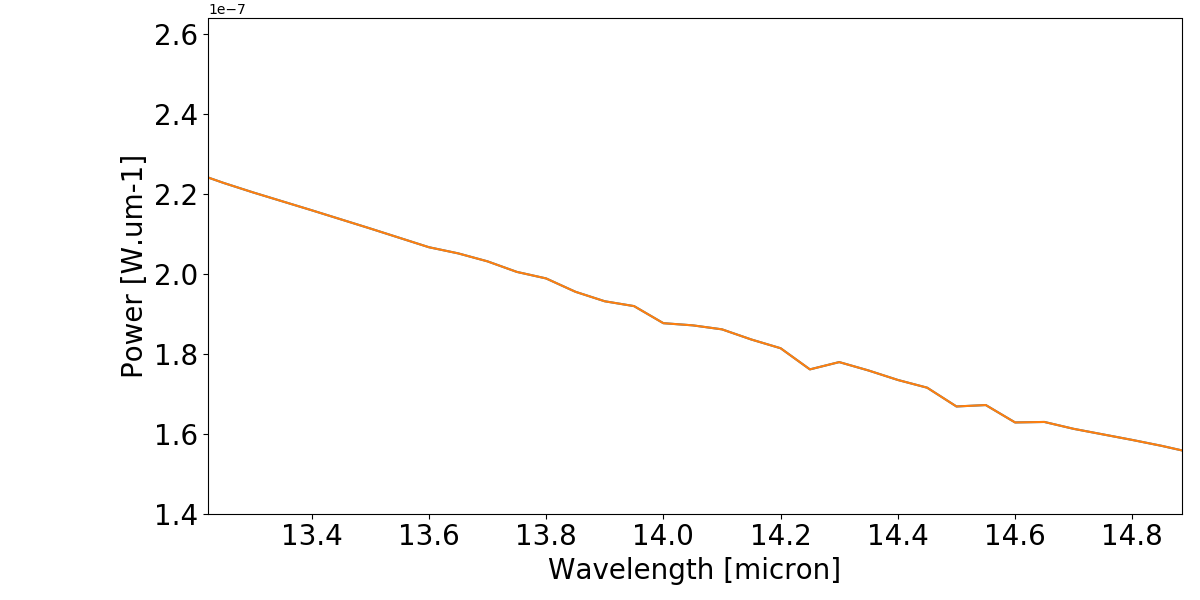

In [26]:
# POM

Vdata = POM(Vdata, config, stt)
Vdata_POM = Vdata.copy()

if plot:
    plt.figure(figsize=(12,6))
    plt.plot(Vdata_OBA['wave'],Vdata_OBA['SPC'])
    plt.plot(Vdata_POM['wave'],Vdata_POM['SPC'])
    plt.xlabel('Wavelength [micron]',fontsize=20)
    plt.ylabel('Power [W.um-1]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

<IPython.core.display.Javascript object>


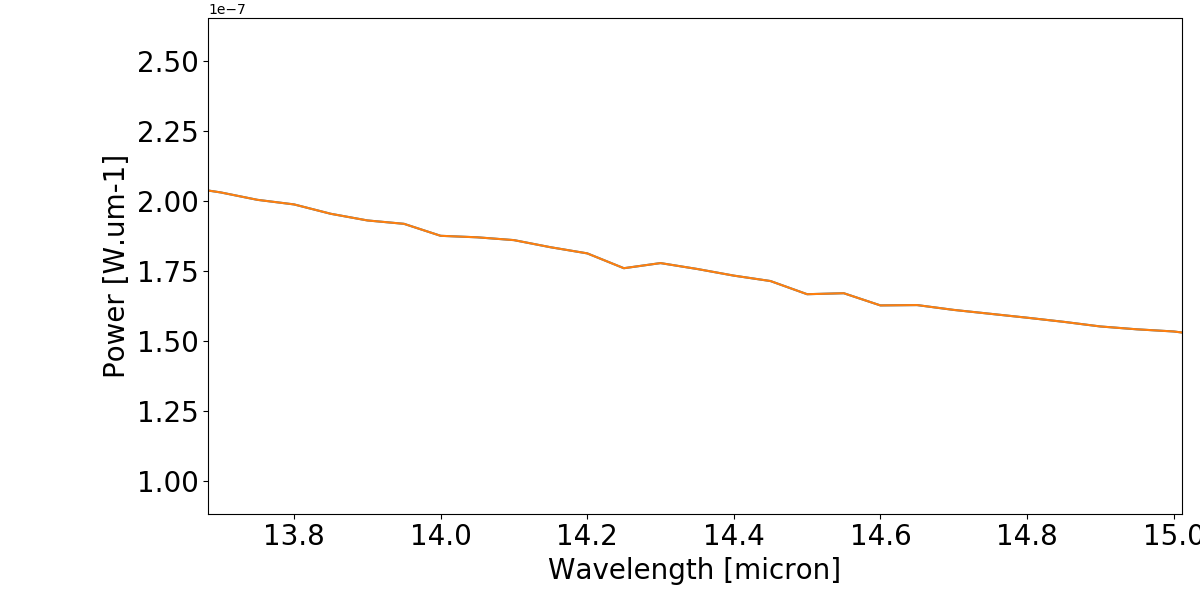

In [27]:
# ADDUP BKG

Vdata = ADDUP_BKG(Vdata, config, stt)
Vdata_ADDUP_BKG = Vdata.copy()

if plot:
    plt.figure(figsize=(12,6))
    plt.plot(Vdata_POM['wave'],Vdata_POM['SPC'])
    plt.plot(Vdata_ADDUP_BKG['wave'],Vdata_ADDUP_BKG['SPC'])
    plt.xlabel('Wavelength [micron]',fontsize=20)
    plt.ylabel('Power [W.um-1]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

<IPython.core.display.Javascript object>


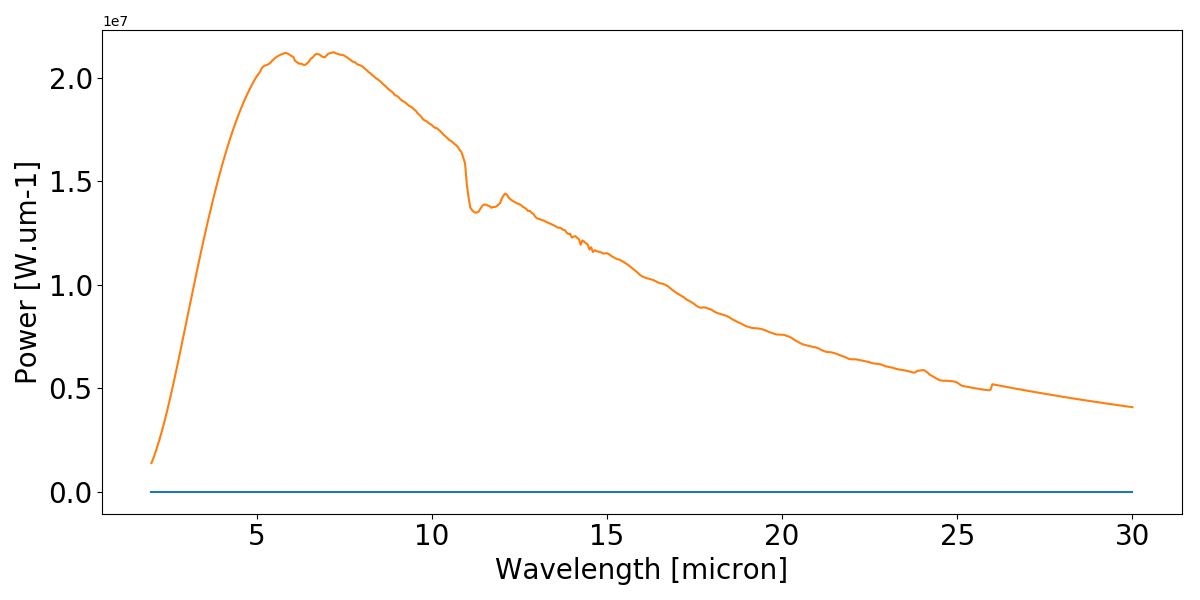

In [28]:
# _CONVERT_

Vdata = _CONVERT(Vdata, config, stt)
Vdata_CONVERT = Vdata.copy()

if plot:
    plt.figure(figsize=(12,6))
    plt.plot(Vdata_ADDUP_BKG['wave'],Vdata_ADDUP_BKG['SPC'])
    plt.plot(Vdata_CONVERT['wave'],Vdata_CONVERT['SPC'])
    plt.xlabel('Wavelength [micron]',fontsize=20)
    plt.ylabel('Power [W.um-1]',fontsize=20)
    plt.tick_params(axis='both',labelsize=20)
    plt.tight_layout()

0.00765114668403 0.131059674666


<IPython.core.display.Javascript object>


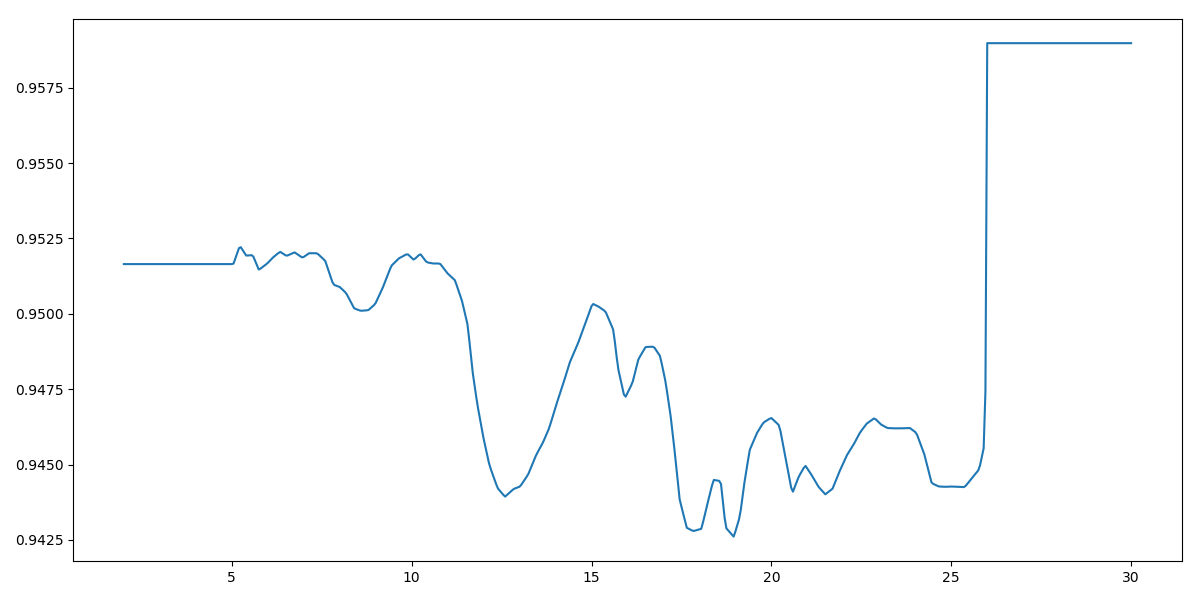

<IPython.core.display.Javascript object>


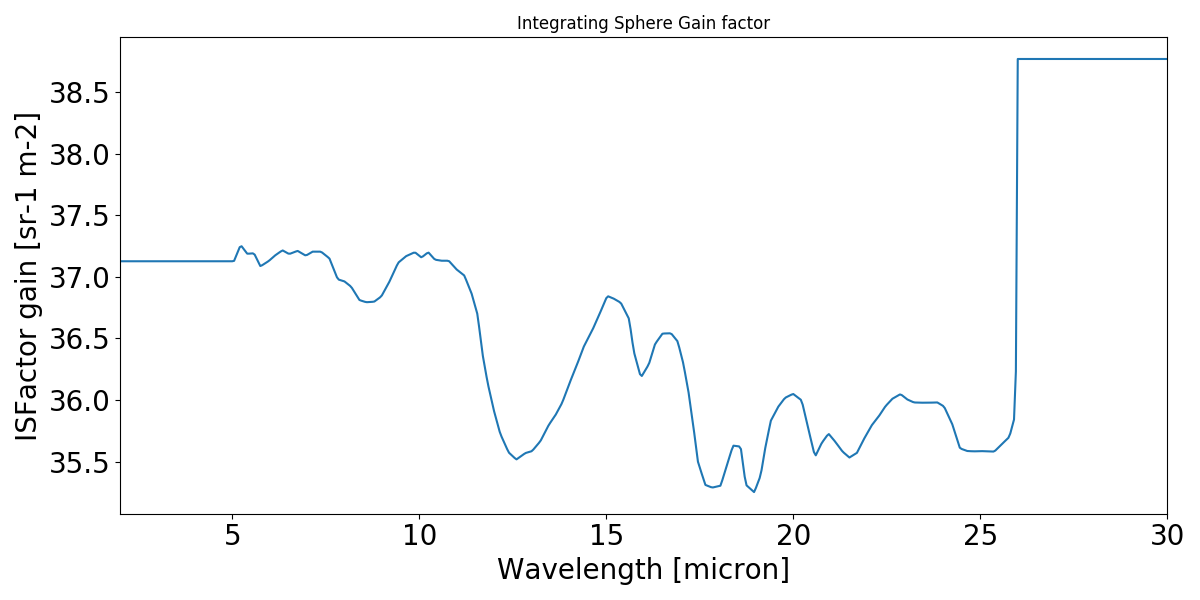

<IPython.core.display.Javascript object>


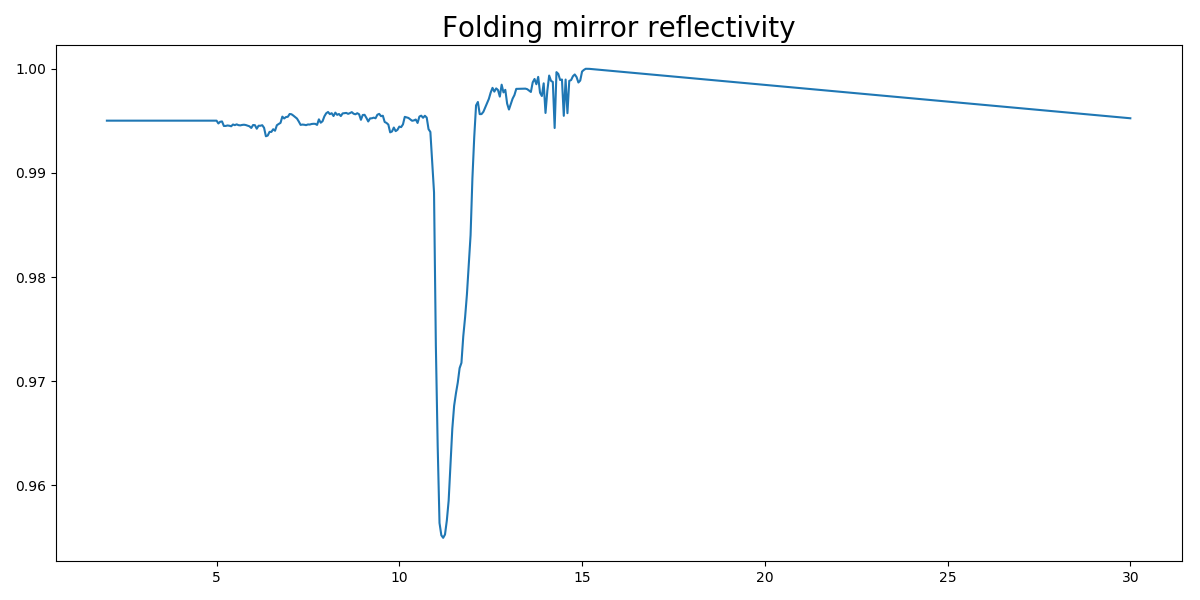

<IPython.core.display.Javascript object>


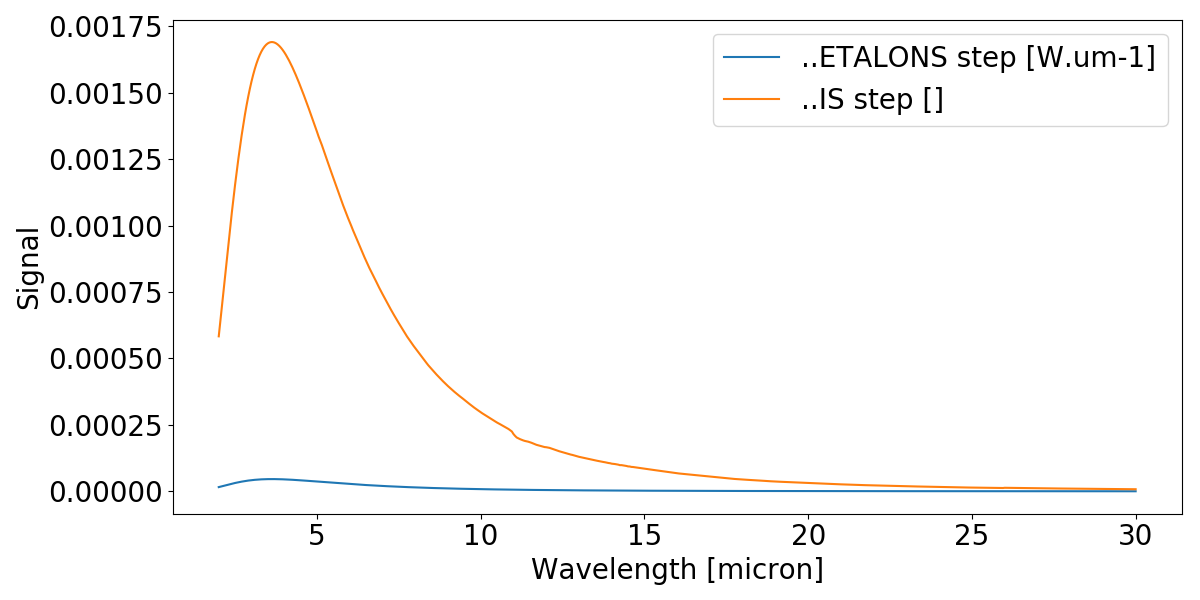

In [17]:
# IS
from numpy import pi,tan
from loadtrans import LoadTrans

spcP = Vdata['SPC']  # W.m-2.um-1
wave = Vdata['wave'] # um-1

assert Vdata['spc_id'] == 'P','Expecting units of "P", but got {} instead.'.format(Vdata['spc_id'])

beam_divergence = config['beam_divergence']

Area_sphere = 4. * pi * (stt['R_sphere']*1.E-3)**2. # m2
IS_aperture = stt['ap_collimator'] + tan(beam_divergence) * stt['dist_coll_IS']
                                                         # mm
                                                         # Beam diameter

# Input = smallest of beam or input port diameter

assert stt['ap_input_port'] >= IS_aperture,'**WARNING** Input port smaller than beam **WARNING**' # WHAT TO DO??

Area_input_port = pi * (IS_aperture * 1.E-3 / 2.)**2.  # m2 (circular)
Area_output_port = (stt['ap_output_port'] * 1.E-3)**2. # m2 (squared)

print Area_input_port/Area_sphere,Area_output_port/Area_sphere


# APPLICATION OF THE "TRANSMISSION" CURVE OF THE IS

iTrans_IS = LoadTrans(stt['Tpath'] + stt['ISTransn'], wave)

plt.figure(figsize=(12,6))
plt.plot(wave,iTrans_IS)
plt.tight_layout()

# Two useful ratios:

fj = (Area_input_port + Area_output_port) / Area_sphere
                                                          # Area efficiency
                                                          # of the IS
fe = Area_output_port / Area_sphere



# PREVIOUSLY (2.2<v<2.4)

# ISFactor2 = iTrans_IS * fe / (pi * Area_output_port * (1. - iTrans_IS * (1. - fj))) # Equivalent to the next expression

ISFactor = iTrans_IS / (pi * Area_sphere * (1. - iTrans_IS * (1. - fj))) #

plt.figure(figsize=(12,6))
plt.title('Integrating Sphere Gain factor')
plt.plot(wave,ISFactor)
plt.xlim(wave[0],wave[-1])
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel(r'ISFactor gain [sr-1 m-2]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

ISFactor *= stt['ISFctr']                  # scaling

spcL = spcP * ISFactor                     # RADIANCE (W.m-2.um-1)

iTrans_FM = LoadTrans(stt['Tpath'] + stt['MOSTransn'], wave) # transmission of folding mirror, assumed same as MOS FMs.
rho_IS =  iTrans_FM.copy()

plt.figure(figsize=(12,6))
plt.title('Folding mirror reflectivity',fontsize=20)
plt.plot(wave,rho_IS)
plt.tight_layout()

spcL *= rho_IS**2.	               # due to the folding mirror.
                                           # Minor loss.

Vdata['SPC'] = spcL
Vdata['spc_id'] = 'L'

# BACKGROUND

# BACKGROUND contribution of the "IS" deemed NEGLIGIBLE. (Comment by Yannis: It would appear that the background contribution of the "IS" is in fact not negligible in the longest MRS wavelengths..)

assert Vdata['BKG_id'] == 'P','Expecting units of "P", but got {} instead.'.format(Vdata['BKG_id'])

Vdata['BKG_BBFRAME'] *= ISFactor * stt['ro_optica'] 	# RADIANCE, L
Vdata['BKG_BBSTRAP'] *= ISFactor * stt['ro_optica'] 	# RADIANCE, L

Vdata['BKG_VAS'] *= ISFactor * stt['ro_optica'] 	  	# RADIANCE, L

Vdata['BKG_id'] = 'L'

Vdata_IS = Vdata.copy()

plt.figure(figsize=(12,6))
plt.plot(Vdata_ETALONS['wave'],Vdata_ETALONS['SPC'],label='..ETALONS step [W.um-1]')
plt.plot(Vdata_IS['wave'],Vdata_IS['SPC'],label='..IS step []')
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('Signal',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.legend(loc='upper right',fontsize=20)
plt.tight_layout()

In [12]:
print fj

0.13871082135


In [13]:
from numpy import arcsin
phi = 2.*arcsin((stt['ap_output_port']/2.)/stt['R_sphere'])

print stt['ap_output_port'],stt['R_sphere']*phi,(stt['R_sphere']*phi)*stt['ap_output_port'] * 10**-6
print Area_output_port

77.0 83.6003172397 0.00643722442745
0.005929


<IPython.core.display.Javascript object>


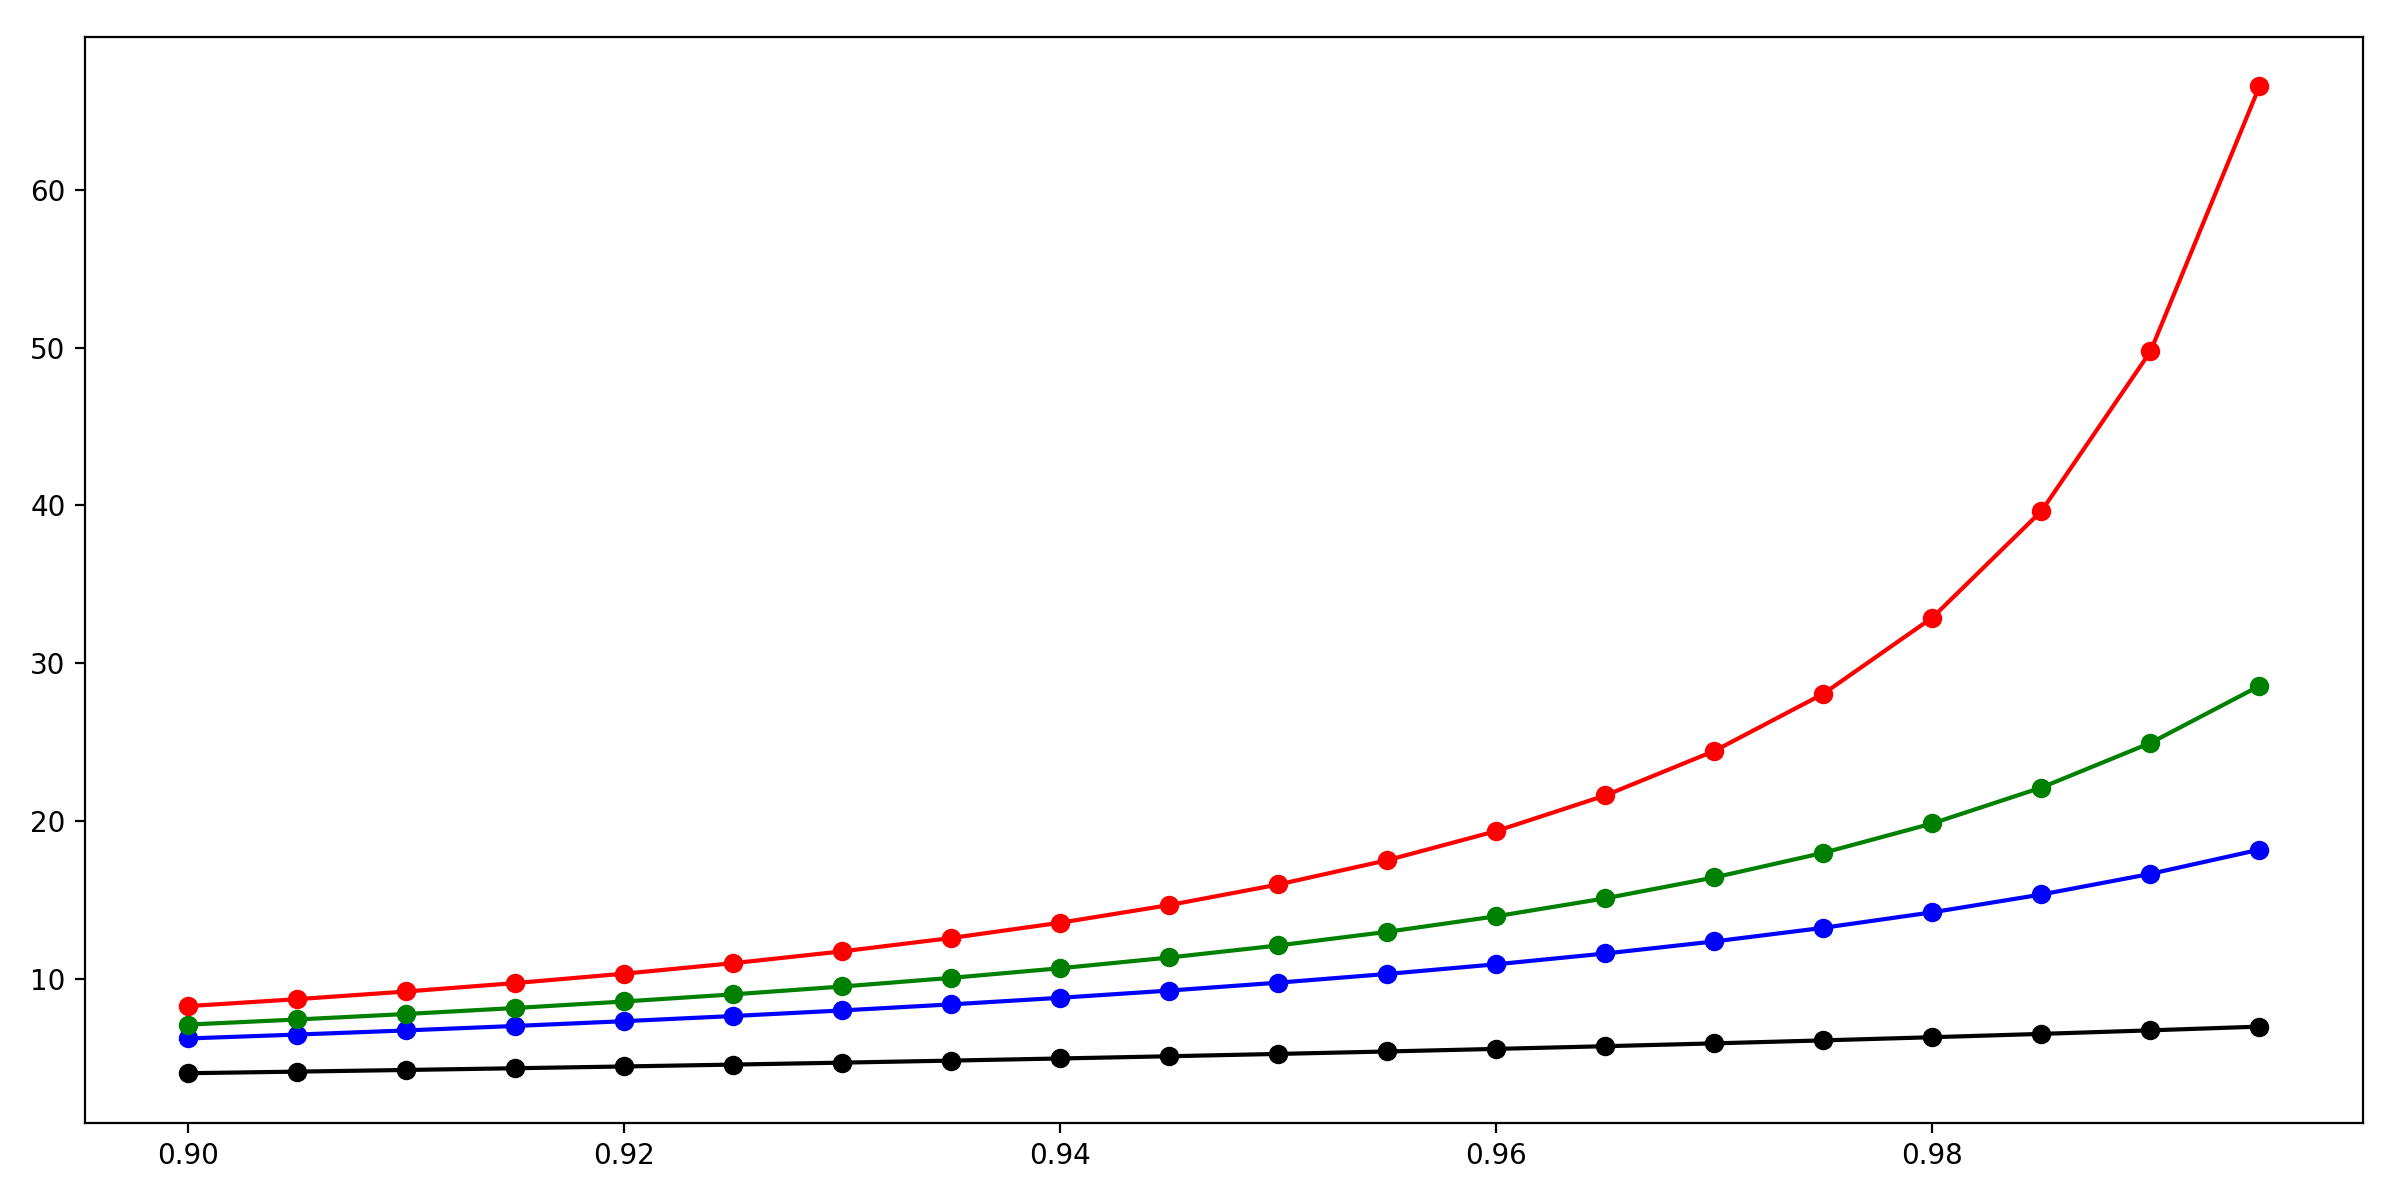

In [14]:
from numpy import arange
rho_w = arange(0.9,1,0.005)

M1 = rho_w / (1-rho_w*(1-0.05))
M2 = rho_w / (1-rho_w*(1-0.03))
M3 = rho_w / (1-rho_w*(1-0.01))
M4 = rho_w / (1-rho_w*(1-fj))

plt.figure(figsize=(12,6))
plt.plot(rho_w,M1,'b')
plt.plot(rho_w,M1,'bo')
plt.plot(rho_w,M2,'g')
plt.plot(rho_w,M2,'go')
plt.plot(rho_w,M3,'r')
plt.plot(rho_w,M3,'ro')
plt.plot(rho_w,M4,'k')
plt.plot(rho_w,M4,'ko')
plt.tight_layout()

<IPython.core.display.Javascript object>


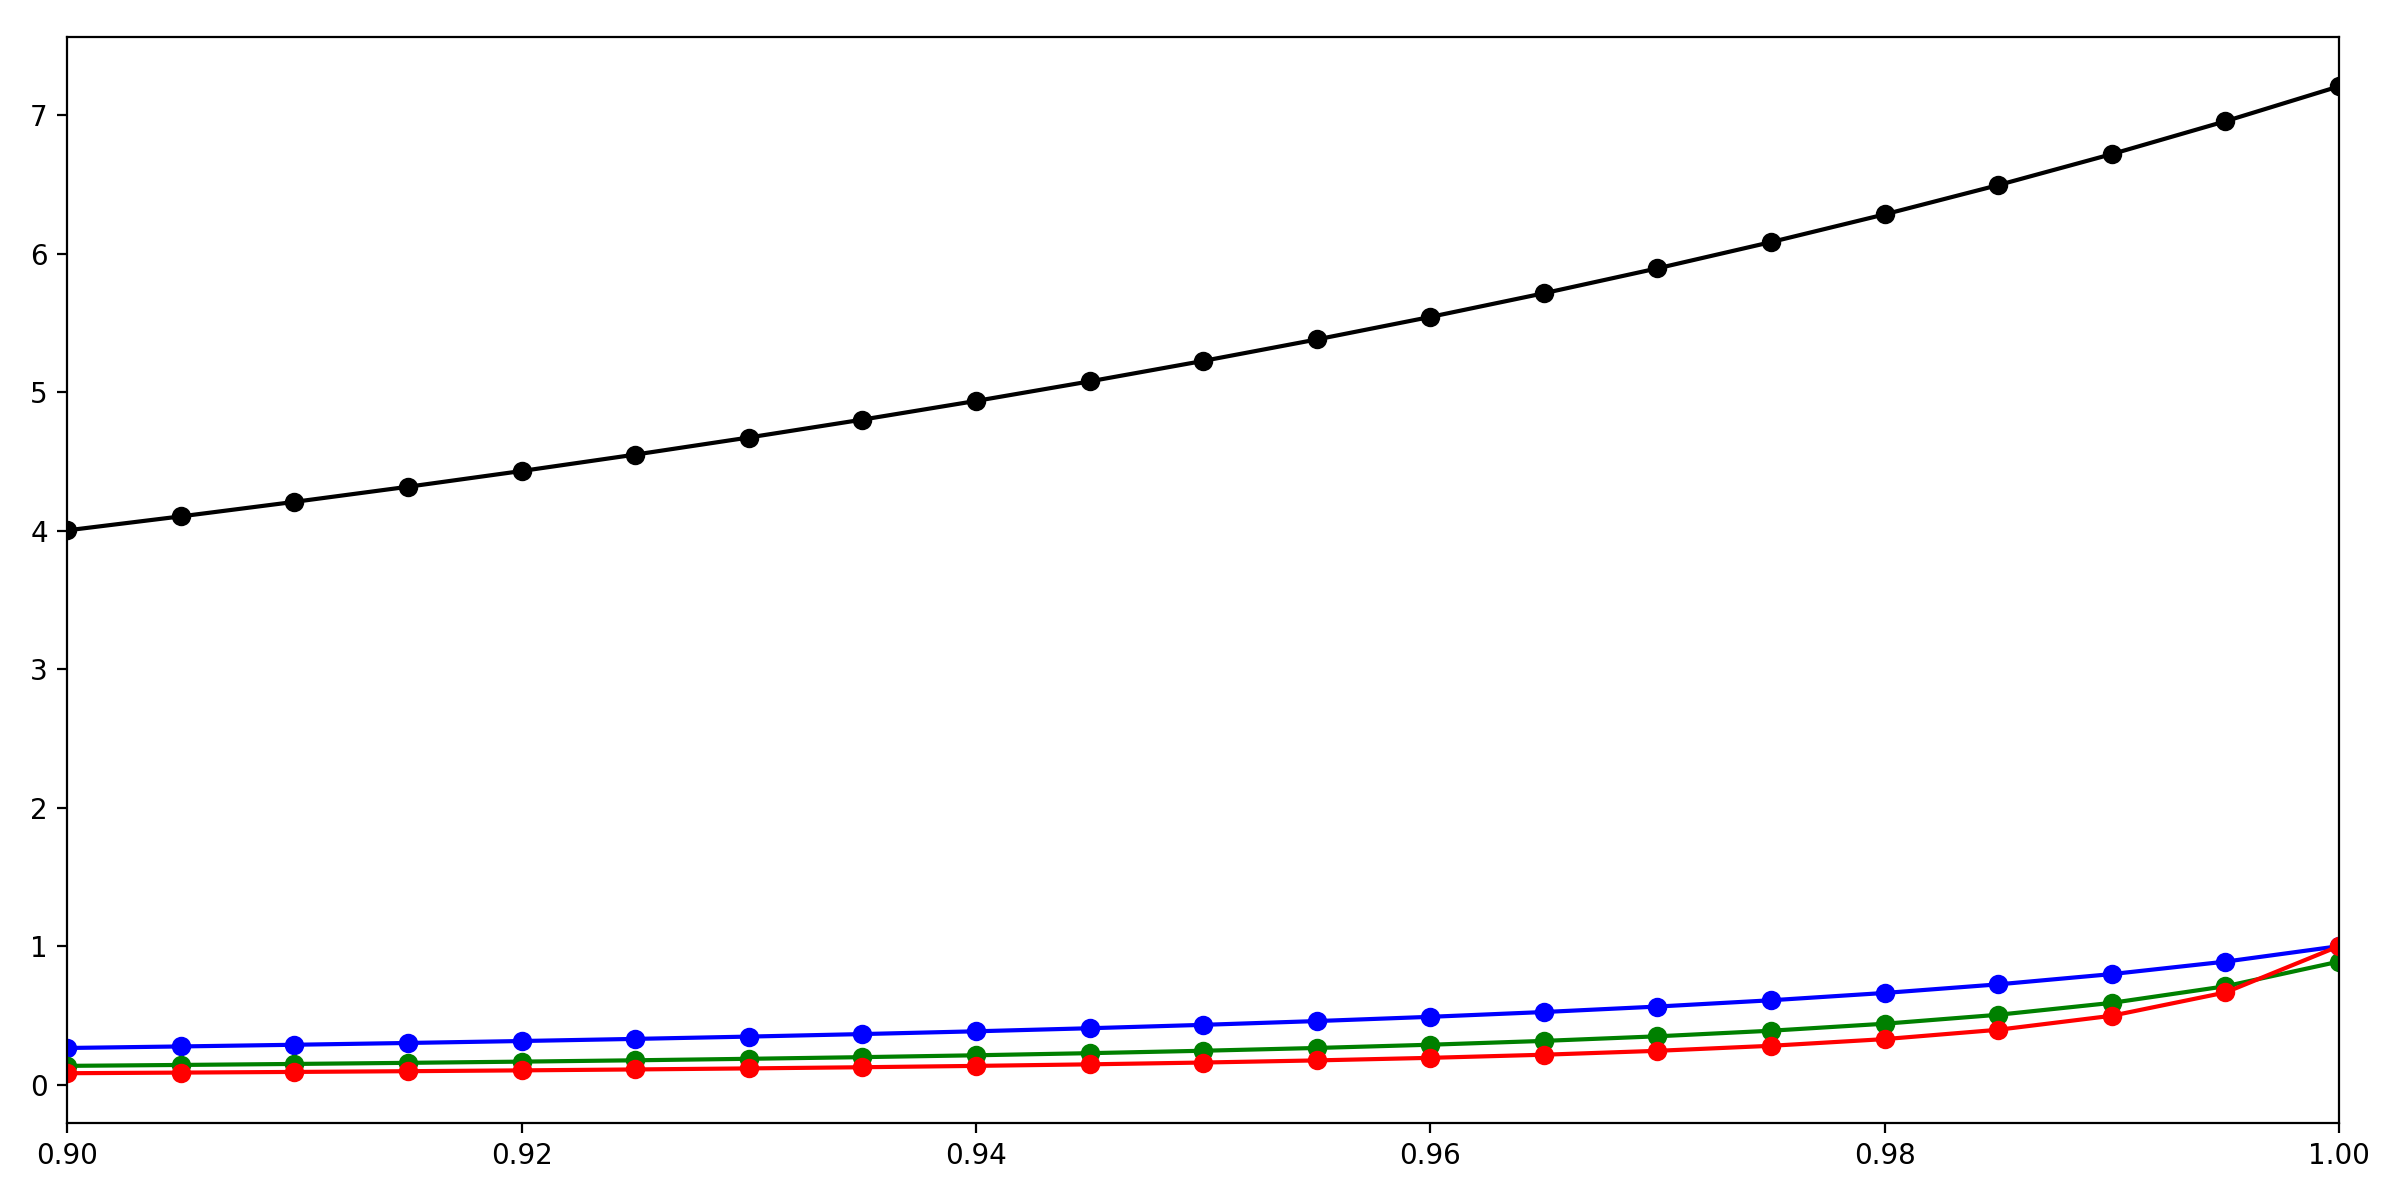

In [15]:
from numpy import arange
rho_w = arange(0.9,1.005,0.005)

M1 = rho_w / (1-rho_w*(1-0.04))
M2 = rho_w / (1-rho_w*(1-0.02))
M3 = rho_w / (1-rho_w*(1-0.01))
M4 = rho_w / (1-rho_w*(1-fj))

L1 = M1 / 5.**2.
L2 = M2 / 7.5**2.
L3 = M3 / 10.**2.
L4 = M4 / (2.*stt['R_sphere']/25.4)**2

plt.figure(figsize=(12,6))
plt.plot(rho_w,L1,'b')
plt.plot(rho_w,L1,'bo')
plt.plot(rho_w,L2,'g')
plt.plot(rho_w,L2,'go')
plt.plot(rho_w,L3,'r')
plt.plot(rho_w,L3,'ro')
plt.plot(rho_w,M4,'k')
plt.plot(rho_w,M4,'ko')
plt.xlim(0.9,1.)
plt.tight_layout()

In [16]:
def IS_reflections(rho,f,n):
    total = 0
    for i_n in range(1,n):
        subtotal = rho**i_n * (1-f)**i_n
#         print subtotal
        total += subtotal
    inf_reflections = rho * (1-f)/(1-rho*(1-f))
    return total/inf_reflections

print IS_reflections(0.95,fj,10)

0.835618339157


In [20]:
print 0.95 * (1 - 0.01)
print 0.95 * (1 - 0.1)

0.9405
0.855


<IPython.core.display.Javascript object>


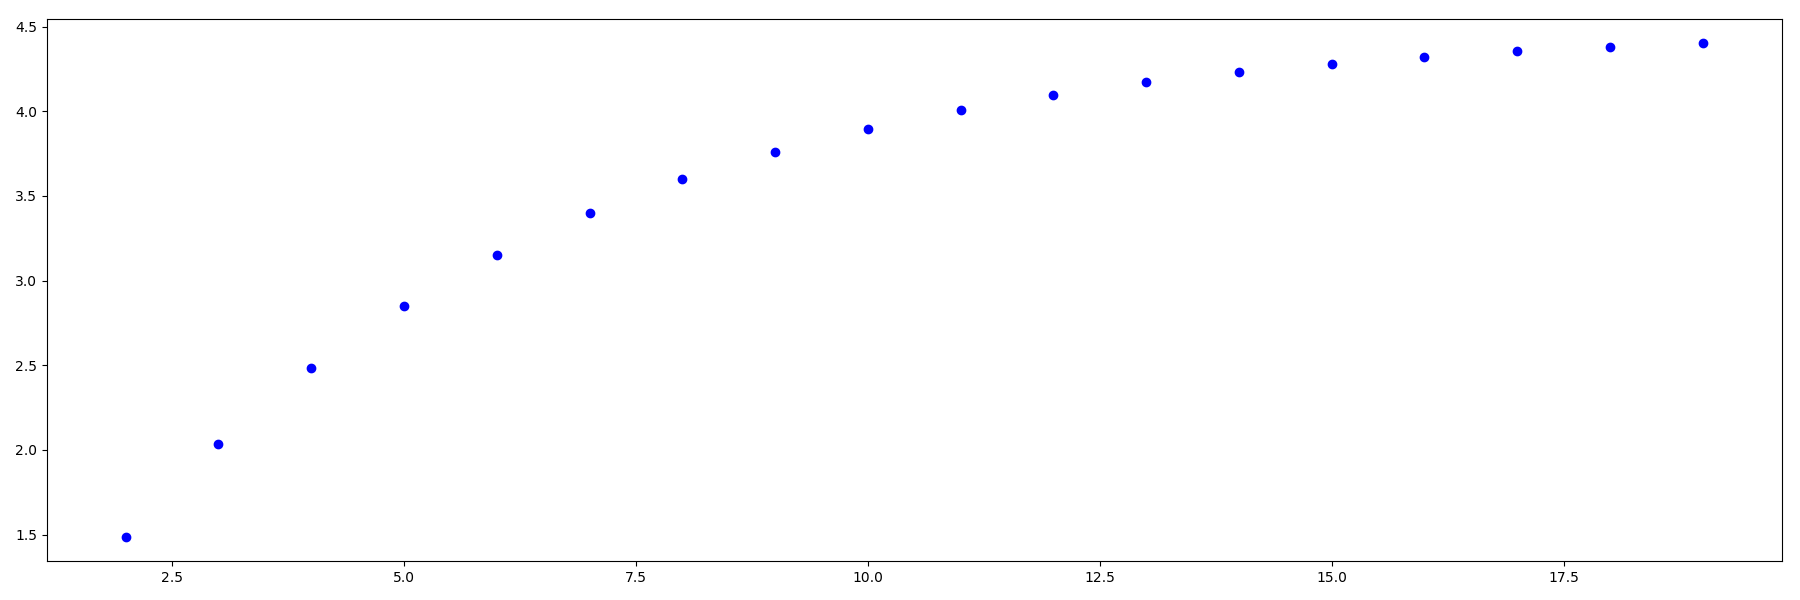

0.669491691957
0.547794652005
0.4482191256
0.366743968416
0.300078980766
0.24553203993
0.200900384554
0.164381660843
0.13450113837
0.110052156244
0.0900473946974
0.0736790042876
0.0602859826323
0.0493274812422
0.0403609645138
0.0330243388769
0.0270213304214
0.0221095205104


In [36]:
plt.figure(figsize=(18,6))
fac = 0.95 * (1-fj)
for n in range(2,20):
    print 0.95**n * (1-fj)**n
    fac += 0.95**n * (1-fj)**n
    plt.plot(n,fac,'bo')
plt.tight_layout()

<IPython.core.display.Javascript object>


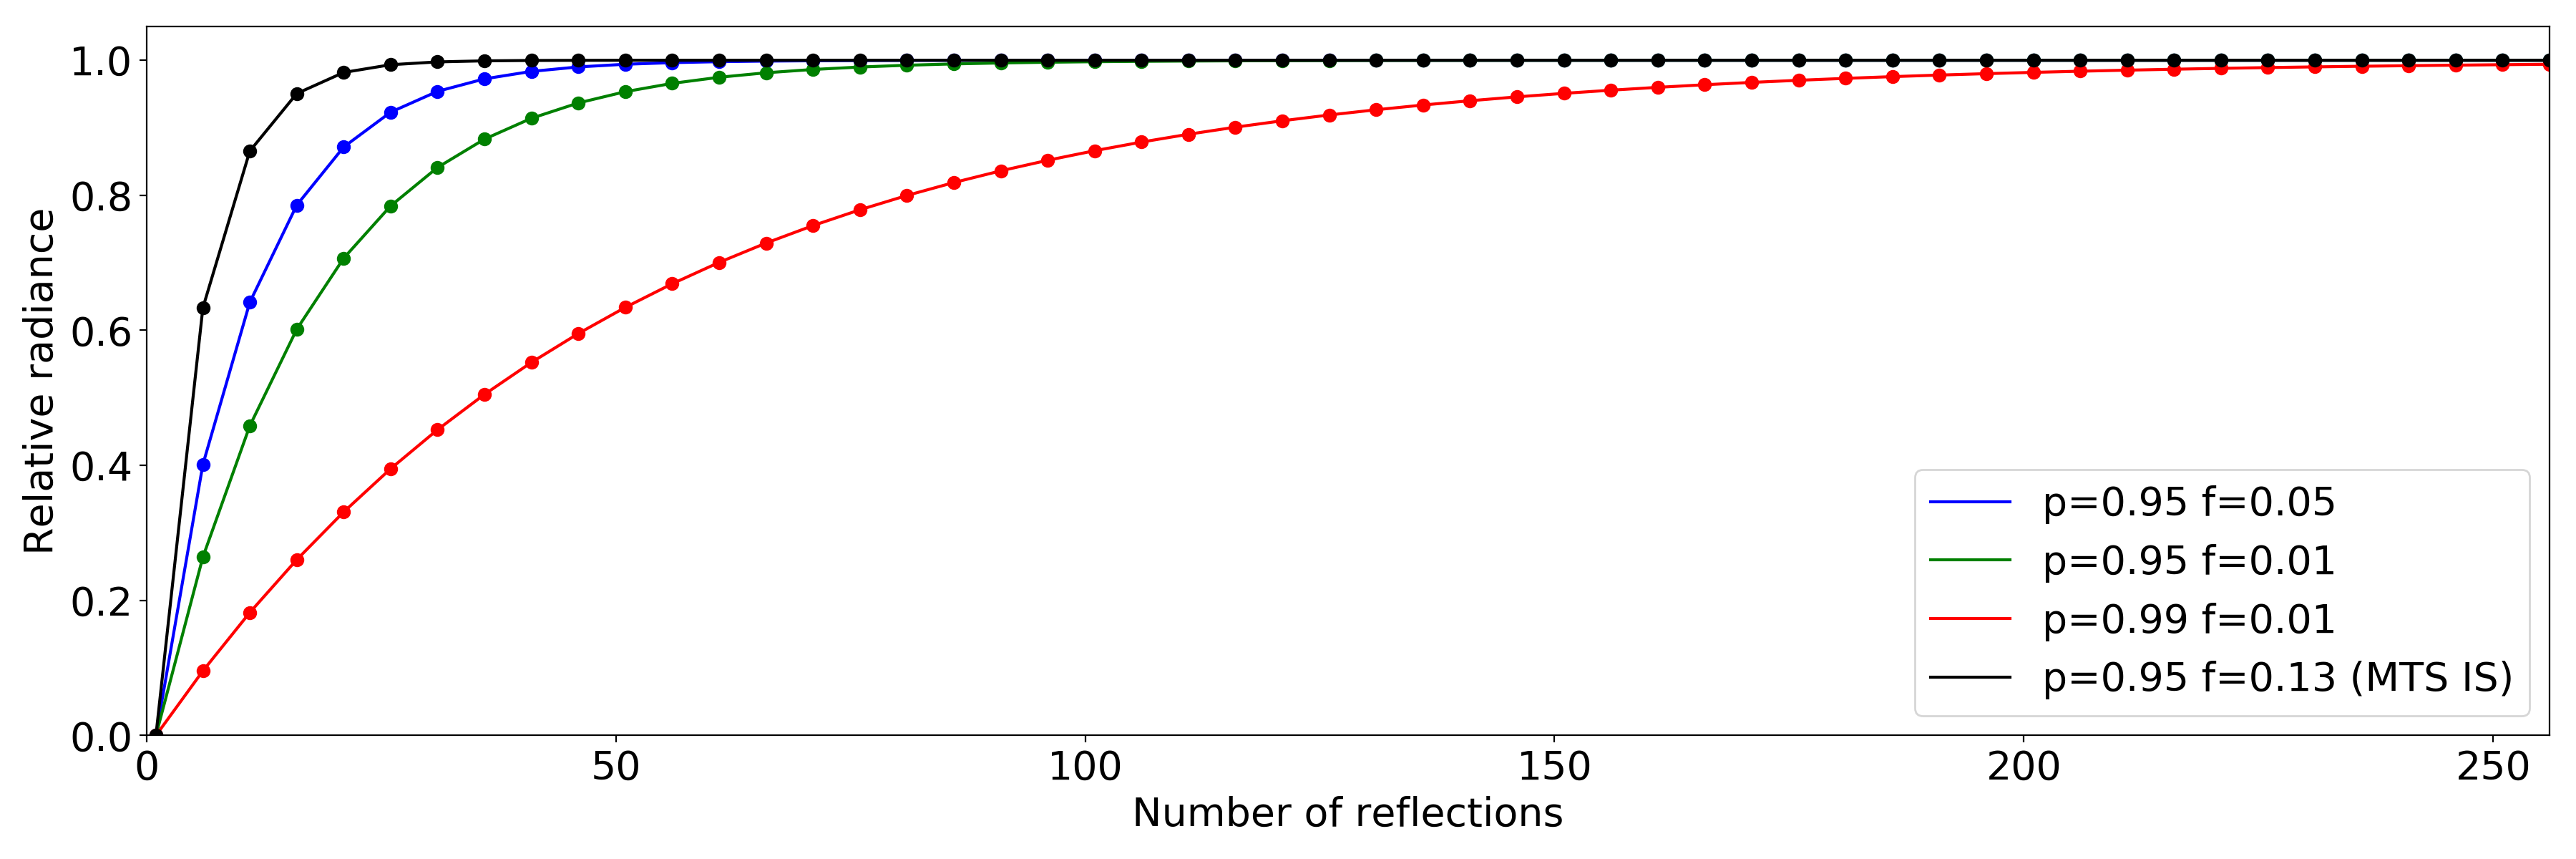

In [17]:
n = arange(1,260,5)

from numpy import zeros

n_reflections1,n_reflections2,n_reflections3,n_reflections4 = [zeros(len(n)) for j in range(4)]
counter = -1
for i_n in n:
    counter +=1
    n_reflections1[counter] = IS_reflections(0.95,0.05,i_n)
    n_reflections2[counter] = IS_reflections(0.95,0.01,i_n)
    n_reflections3[counter] = IS_reflections(0.99,0.01,i_n)
    n_reflections4[counter] = IS_reflections(0.95,fj,i_n)

plt.figure(figsize=(18,6))
plt.plot(n,n_reflections1,'b',label='p=0.95 f=0.05')
plt.plot(n,n_reflections1,'bo')
plt.plot(n,n_reflections2,'g',label='p=0.95 f=0.01')
plt.plot(n,n_reflections2,'go')
plt.plot(n,n_reflections3,'r',label='p=0.99 f=0.01')
plt.plot(n,n_reflections3,'ro')
plt.plot(n,n_reflections4,'k',label='p=0.95 f=0.13 (MTS IS)')
plt.plot(n,n_reflections4,'ko')
plt.xlim(0,n[-1])
plt.ylim(0)
plt.legend(loc='lower right',fontsize=20)
plt.xlabel('Number of reflections',fontsize=20)
plt.ylabel('Relative radiance',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

<IPython.core.display.Javascript object>


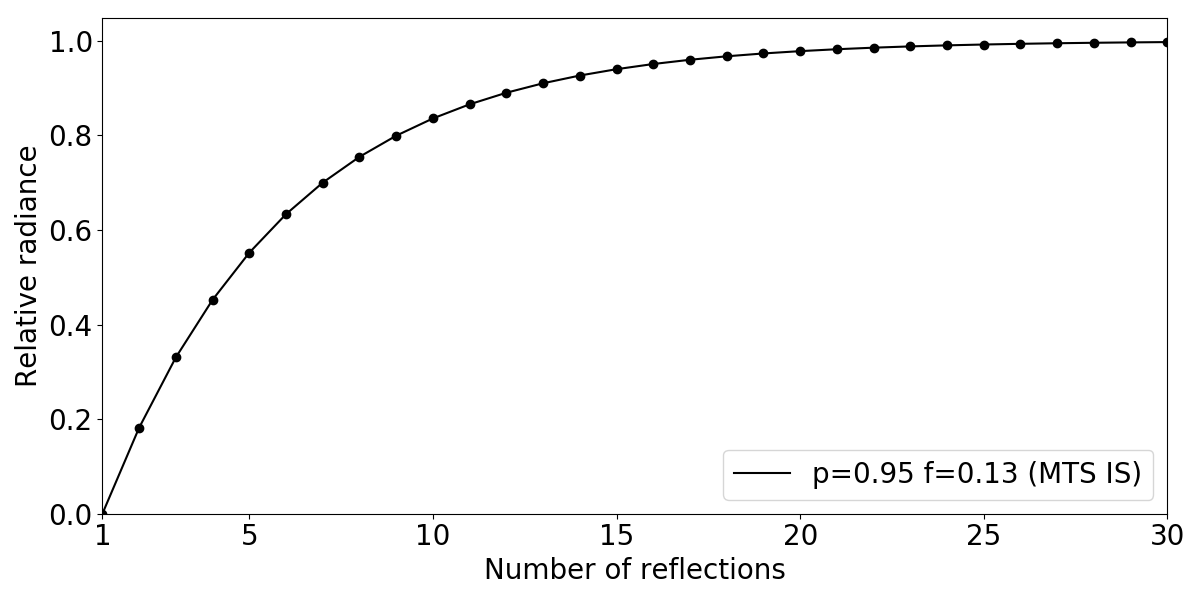

In [18]:
n = arange(1,31)

n_reflections1,n_reflections2,n_reflections3,n_reflections4 = [zeros(len(n)) for j in range(4)]
counter = -1
for i_n in n:
    counter +=1
    n_reflections1[counter] = IS_reflections(0.95,0.05,i_n)
    n_reflections2[counter] = IS_reflections(0.95,0.01,i_n)
    n_reflections3[counter] = IS_reflections(0.99,0.01,i_n)
    n_reflections4[counter] = IS_reflections(0.95,fj,i_n)

tickmarks = [1,5,10,15,20,25,30]
plt.figure(figsize=(12,6))
# plt.plot(n,n_reflections1,'b',label='p=0.95 f=0.05')
# plt.plot(n,n_reflections1,'bo')
# plt.plot(n,n_reflections2,'g',label='p=0.95 f=0.01')
# plt.plot(n,n_reflections2,'go')
# plt.plot(n,n_reflections3,'r',label='p=0.99 f=0.01')
# plt.plot(n,n_reflections3,'ro')
plt.plot(n,n_reflections4,'k',label='p=0.95 f=0.13 (MTS IS)')
plt.plot(n,n_reflections4,'ko')
plt.xticks(tickmarks)
plt.xlim(1,n[-1])
plt.ylim(0)
plt.legend(loc='lower right',fontsize=20)
plt.xlabel('Number of reflections',fontsize=20)
plt.ylabel('Relative radiance',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

In [20]:
from numpy import arctan,pi,sin
r_MTS = (151. * 1.E-3) / 2.                                 # m
phi_MTS = arctan(r_MTS / (3017.56 * 1.E-3))                 # rad

print pi * (sin(phi_MTS))**2. # we multiply by this factor to get W.m-2.um-1

0.00196544166993


<IPython.core.display.Javascript object>


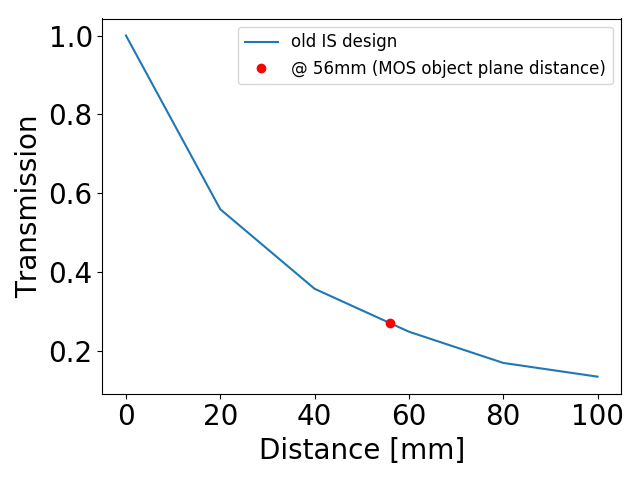

Object plane at 56mm from IS output yields transmission of 27.03 %


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy.interpolate import interp1d

distance = np.array([0.,20.,40.,60.,80.,100.])
flux = np.array([0.1770668,0.0990138,0.06328523,0.04400272,0.02997712,0.02379999])
flux_interp = interp1d(distance,flux)

object_plane_dist = 56. # distance of integrating sphere output to MTS MOS object plane, [mm]

plt.figure()
plt.plot(distance,flux/flux[0],label='old IS design')
plt.plot(56.,flux_interp(object_plane_dist)/flux[0],'ro',label='@ {}mm (MOS object plane distance)'.format(int(object_plane_dist)))
plt.xlabel('Distance [mm]',fontsize=20)
plt.ylabel('Transmission',fontsize=20)
plt.legend(loc='upper right',fontsize=12)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

print 'Object plane at 56mm from IS output yields transmission of {} %'.format(round((flux_interp(object_plane_dist)/flux[0])*100.,2))